In [20]:
import sys
sys.path.append('../code')
from resnet import *
from cifar_very_tiny import *
from cifar_dataset import *    
import torch as t 
import numpy as np
import tqdm
import matplotlib.pylab as plt
import matplotlib.cm as cm
import json
import hyperparams
from importlib import reload
from scipy.interpolate import interp1d
%matplotlib inline
plt.rcParams['figure.figsize']=(12,9)
plt.rcParams['font.size']= 20

In [21]:
# добавил в загрузку валидационную выборку
# обрати внимание, maxsize --- это размер совокпного обучения и валидации
# поэтому размер обучающей выборки совпадает с тем, что было до этого
_, test_loader, train_loader_no_augumentation, valid_loader = cifar10_loader(batch_size=128, split_train_val=True,
                                                                             maxsize=10112*2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# epoch_num = 200
epoch_num = 50
run_num = 5 # количество запусков эксперимента
# версия нужна, чтобы различать старые и новые результаты экспериментов. 
# менять нужно каждый раз, когда есть хотя бы незначительные изменения в эксперименте
experiment_version = '10' 

validate_every_epoch = 5 
# spline_mode = 'linear' #полиномом какой степени пользуемся, смотри функцию scipy.interpolate.interp1d
# spline_mode = 'quadratic'
spline_mode = 'cubic'
train_splines_every_epoch = 5 # каждые 5 эпох отслеживать траекторию гиперпараметров
# train_splines_every_epoch = 2
# train_splines_every_epoch = 3
# train_splines_every_epoch = 10

In [23]:
def accuracy(student):
        student.eval()
        total = 0 
        correct = 0
        with t.no_grad():
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)
                out = student(x)
                correct += t.eq(t.argmax(out, 1), y).sum()
                total+=len(x)
        student.train()
        return (correct/total).cpu().detach().numpy()

In [24]:
kl = nn.KLDivLoss(reduction='batchmean')
sm = nn.Softmax(dim=1)

def distill(out, batch_logits, temp):
    g = sm(out/temp)
    f = F.log_softmax(batch_logits/temp)    
    return kl(f, g)

In [25]:
# Запуск --- с CNN-дистилляцией и оптимизацией гиперпараметров, 2-beta
crit = nn.CrossEntropyLoss()

# определяем функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def param_loss(batch,model,h):
    x,y,batch_logits = batch
    beta,beta2,temp = h
    out = model(x)
    beta = t.clamp(beta, 0.01, 0.99) # todo
    beta2 = t.clamp(beta2, 0.01, 0.99) #todo
    temp = t.clamp(temp, 0.1, 10.0) #todo
    distillation_loss = distill(out, batch_logits, temp)
    student_loss = crit(out, y)            
    loss = beta2 * student_loss + beta*distillation_loss
    return loss

# определяем функцию валидационную функцию потерь как замкнутую относительно аргументов функцию
# нужно для подсчета градиентов гиперпараметров по двухуровневой оптимизации
def hyperparam_loss(batch, model):
    x,y = batch
    out = model(x)
    student_loss = crit(out, y)            
    return student_loss

logits = np.load('../code/logits_cnn.npy')
for _ in range(run_num):
    internal_results = []    
    # теперь beta и temp - не числа, а тензоры, по которым можно считать градиент
    beta = t.nn.Parameter(t.tensor(np.random.uniform(), device=device), requires_grad=True)
    beta2 = t.nn.Parameter(t.tensor(np.random.uniform(), device=device), requires_grad=True)
    temp = t.nn.Parameter(t.tensor(10**np.random.uniform(low=-1, high=1), device=device), requires_grad=True)    
    h = [beta, beta2, temp]
    
    student = Cifar_Very_Tiny(10).to(device)
    optim = t.optim.Adam(student.parameters())   
    
    # параметры Adam и функцию подсчета градиента 
    # взял из статьи по DARTS (выбор архитектуры сети градиентными методами)
    # там также используется оптимизация гиперпараметров
    optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
    hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
    
    
    for e in range(epoch_num): # хочется посмотреть куда сойдутся гиперпараметры, поэтому возьмем побольше эпох
        if e % train_splines_every_epoch == 0:
            spline_hist = []
            spline_id  = -1 
            optim2 = t.optim.Adam(h,  betas=(0.5, 0.999))   
            hyper_grad_calc = hyperparams.AdamHyperGradCalculator(student, param_loss, hyperparam_loss, optim, h)
        tq = tqdm.tqdm(zip(train_loader_no_augumentation, valid_loader))
        losses = []
        for batch_id, ((x,y), (v_x, v_y)) in enumerate(tq):
            spline_id += 1
            x = x.to(device)
            y = y.to(device)            
                      
            batch_logits = t.Tensor(logits[128*batch_id:128*(batch_id+1)]).to(device) 
            # если настала пора понаблюдать за траекторий гиперпараметров
            if e % train_splines_every_epoch == 0: 
                v_x = v_x.to(device)
                v_y = v_y.to(device)  
                optim2.zero_grad()            
                hyper_grad_calc.calc_gradients((x,y,batch_logits), (v_x, v_y))            
                optim2.step()                
                spline_hist.append([h_.cpu().detach().numpy() for h_ in h])
            else:
                # иначе гиперпараметры предсказываем на основе сплайнов
                # здесь мы делаем костыль - не даем уйти гиперпараметрам в те значения,
                # в которых градиент потом будет нулевым                
                spline_out = splines(spline_id)
                if beta> 0.1 and spline_out[0]>0.1 and beta<0.9 and spline_out[0]<0.9:                
                    beta.data *= 0
                    beta.data += spline_out[0]
                if beta2> 0.1 and spline_out[1]>0.1 and beta2<0.9 and spline_out[1]<0.9:                
                    beta2.data *= 0
                    beta2.data += spline_out[1]
                if temp> 0.5 and spline_out[2]>0.5 and temp<9.5 and spline_out[2]<9.5:                
                    temp.data *= 0
                    temp.data += spline_out[2]
            optim.zero_grad()
            loss = param_loss((x,y,batch_logits), student,h)
            losses.append(loss.cpu().detach().numpy())
            loss.backward()
            optim.step()
            tq.set_description('current loss:{}'.format(np.mean(losses[-10:])))
        
        # если мы отслеживали траекторию эпохи - можно обучить на этом сплайны
        if e % train_splines_every_epoch == 0:
            splines = interp1d(range(len(spline_hist)), spline_hist, axis=0,
                               fill_value='extrapolate', kind=spline_mode)
        
        
        if e==0 or (e+1)%validate_every_epoch == 0: # если номер эпохи делится на 5 или эпоха - первая             
            test_loss = []
            student.eval()
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss.append(crit(student(x), y).detach().cpu().numpy())                 
            test_loss = float(np.mean(test_loss))
            test_loss2 = []            
            for x,y in test_loader:
                x = x.to(device)
                y = y.to(device)                            
                test_loss2.append(crit(student(x), y).detach().cpu().numpy())                 
            print (float(np.mean(test_loss2)))
            
            
            acc = float(accuracy(student))
            student.train()
            internal_results.append({'epoch': e, 'test loss':test_loss, 'accuracy':acc, 
                                     'temp':float(h[2].detach().cpu().numpy()),
                                     'beta':float(h[0].detach().cpu().numpy()),
                                    'beta2':float(h[1].detach().cpu().numpy())})
            print (internal_results[-1])

            
    with open('exp'+experiment_version+'_dist_h_b2_optim.jsonl', 'a') as out:
        out.write(json.dumps({'results':internal_results, 'version': experiment_version})+'\n')

0it [00:00, ?it/s]<ipython-input-24-cea0592a0b8b>:6: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  f = F.log_softmax(batch_logits/temp)
current loss:5.176440715789795: : 79it [00:10,  7.37it/s] 


1.7585748434066772


current loss:5.1370015144348145: : 2it [00:00, 14.28it/s]

{'epoch': 0, 'test loss': 1.7664588689804077, 'accuracy': 0.33379998803138733, 'temp': 0.6335951685905457, 'beta': 0.3798713684082031, 'beta2': 0.849064826965332}


current loss:4.237217903137207: : 79it [00:05, 14.40it/s] 
current loss:3.630516767501831: : 79it [00:05, 14.28it/s] 
current loss:3.2358322143554688: : 79it [00:05, 14.14it/s]
current loss:2.963325262069702: : 79it [00:05, 14.37it/s] 


1.4200948476791382


current loss:2.693474769592285: : 1it [00:00,  6.75it/s]

{'epoch': 4, 'test loss': 1.4293498992919922, 'accuracy': 0.5060999989509583, 'temp': 0.6335951685905457, 'beta': 0.3798713684082031, 'beta2': 0.849064826965332}


current loss:2.513890504837036: : 79it [00:10,  7.24it/s] 
current loss:2.3579392433166504: : 79it [00:05, 14.81it/s]
current loss:2.2242591381073: : 79it [00:05, 14.19it/s]   
current loss:2.1065919399261475: : 79it [00:05, 14.23it/s]
current loss:2.008261203765869: : 79it [00:05, 14.30it/s] 


1.3536485433578491


current loss:1.9107918739318848: : 1it [00:00,  7.20it/s]

{'epoch': 9, 'test loss': 1.3440873622894287, 'accuracy': 0.5479000210762024, 'temp': 0.6607726812362671, 'beta': 0.34571707248687744, 'beta2': 0.8125908374786377}


current loss:1.7768423557281494: : 79it [00:10,  7.32it/s]
current loss:1.704545021057129: : 79it [00:05, 14.08it/s] 
current loss:1.6639301776885986: : 79it [00:05, 14.49it/s]
current loss:1.6201425790786743: : 79it [00:05, 14.47it/s]
current loss:1.5744388103485107: : 79it [00:05, 14.26it/s]


1.3819048404693604


current loss:1.5155620574951172: : 1it [00:00,  6.94it/s]

{'epoch': 14, 'test loss': 1.391559362411499, 'accuracy': 0.5552999973297119, 'temp': 0.6843295693397522, 'beta': 0.31273818016052246, 'beta2': 0.7874078154563904}


current loss:1.4562369585037231: : 79it [00:10,  7.55it/s]
current loss:1.4182331562042236: : 79it [00:05, 14.26it/s]
current loss:1.3846349716186523: : 79it [00:05, 14.23it/s]
current loss:1.3417017459869385: : 79it [00:05, 13.90it/s]
current loss:1.307397484779358: : 79it [00:05, 14.40it/s] 


1.375549554824829


current loss:1.24349844455719: : 1it [00:00,  6.96it/s]

{'epoch': 19, 'test loss': 1.384535789489746, 'accuracy': 0.5659999847412109, 'temp': 0.696491539478302, 'beta': 0.2916857898235321, 'beta2': 0.7680479288101196}


current loss:1.1621531248092651: : 79it [00:10,  7.39it/s]
current loss:1.1467088460922241: : 79it [00:05, 14.52it/s]
current loss:1.1302459239959717: : 79it [00:05, 14.58it/s]
current loss:1.1061227321624756: : 79it [00:05, 14.62it/s]
current loss:1.0829651355743408: : 79it [00:05, 14.49it/s]


1.4245167970657349


current loss:1.138010025024414: : 1it [00:00,  6.42it/s]

{'epoch': 24, 'test loss': 1.4213430881500244, 'accuracy': 0.5649999976158142, 'temp': 0.7230314612388611, 'beta': 0.25107961893081665, 'beta2': 0.7391389012336731}


current loss:0.9775387048721313: : 79it [00:10,  7.34it/s]
current loss:0.9739974737167358: : 79it [00:05, 14.70it/s]
current loss:0.961774468421936: : 79it [00:05, 14.07it/s] 
current loss:0.9459584355354309: : 79it [00:05, 14.16it/s]
current loss:0.9272158741950989: : 79it [00:05, 14.17it/s]


1.430937647819519


current loss:0.9341375827789307: : 1it [00:00,  7.22it/s]

{'epoch': 29, 'test loss': 1.432746171951294, 'accuracy': 0.5656999945640564, 'temp': 0.7493718266487122, 'beta': 0.2169632762670517, 'beta2': 0.7138685584068298}


current loss:0.8357865214347839: : 79it [00:10,  7.43it/s]
current loss:0.8281563520431519: : 79it [00:05, 15.08it/s]
current loss:0.8228174448013306: : 79it [00:05, 14.98it/s]
current loss:0.8131076097488403: : 79it [00:05, 15.06it/s]
current loss:0.7994398474693298: : 79it [00:05, 15.07it/s]


1.4703094959259033


current loss:0.7565368413925171: : 1it [00:00,  6.81it/s]

{'epoch': 34, 'test loss': 1.462494134902954, 'accuracy': 0.560699999332428, 'temp': 0.7720210552215576, 'beta': 0.18360361456871033, 'beta2': 0.6910575032234192}


current loss:0.7189668416976929: : 79it [00:11,  6.71it/s]
current loss:0.710538387298584: : 79it [00:05, 14.46it/s] 
current loss:0.7011811137199402: : 79it [00:05, 13.91it/s]
current loss:0.6945000886917114: : 79it [00:05, 14.48it/s]
current loss:0.6830580830574036: : 79it [00:05, 14.62it/s]


1.4949760437011719


current loss:0.6655870079994202: : 1it [00:00,  6.94it/s]

{'epoch': 39, 'test loss': 1.485887050628662, 'accuracy': 0.566100001335144, 'temp': 0.7992271780967712, 'beta': 0.14566347002983093, 'beta2': 0.663644552230835}


current loss:0.6150764226913452: : 79it [00:10,  7.39it/s]
current loss:0.6097875237464905: : 79it [00:05, 14.73it/s]
current loss:0.5968253016471863: : 79it [00:05, 14.83it/s]
current loss:0.5847752690315247: : 79it [00:05, 14.77it/s]
current loss:0.5739533305168152: : 79it [00:05, 14.45it/s]


1.5140775442123413


current loss:0.5805805921554565: : 1it [00:00,  7.11it/s]

{'epoch': 44, 'test loss': 1.5242478847503662, 'accuracy': 0.5662000179290771, 'temp': 0.8153772950172424, 'beta': 0.11571913957595825, 'beta2': 0.6440823674201965}


current loss:0.5257216691970825: : 79it [00:10,  7.48it/s]
current loss:0.5152088403701782: : 79it [00:05, 14.39it/s] 
current loss:0.5075716972351074: : 79it [00:05, 14.63it/s] 
current loss:0.50126051902771: : 79it [00:05, 14.59it/s]   
current loss:0.4940955638885498: : 79it [00:05, 14.41it/s] 


1.578662633895874


current loss:0.5090946555137634: : 1it [00:00,  6.39it/s]

{'epoch': 49, 'test loss': 1.572924017906189, 'accuracy': 0.5630999803543091, 'temp': 0.8231773376464844, 'beta': 0.09125189483165741, 'beta2': 0.6315532922744751}


current loss:0.4507271647453308: : 79it [00:11,  7.13it/s] 
current loss:0.44229936599731445: : 79it [00:05, 14.46it/s]
current loss:0.4346247613430023: : 79it [00:05, 14.32it/s] 
current loss:0.42554011940956116: : 79it [00:05, 14.67it/s]
current loss:0.41942209005355835: : 79it [00:05, 14.37it/s]


1.6791123151779175


current loss:0.45149165391921997: : 1it [00:00,  7.29it/s]

{'epoch': 54, 'test loss': 1.667374849319458, 'accuracy': 0.5551999807357788, 'temp': 0.8312196135520935, 'beta': 0.06778139621019363, 'beta2': 0.616357147693634}


current loss:0.3728479743003845: : 79it [00:10,  7.45it/s] 
current loss:0.3714236915111542: : 79it [00:05, 14.47it/s] 
current loss:0.36868083477020264: : 79it [00:05, 14.17it/s]
current loss:0.36408302187919617: : 79it [00:05, 14.43it/s]
current loss:0.36079585552215576: : 79it [00:05, 14.87it/s]


1.7387316226959229


current loss:0.38079750537872314: : 1it [00:00,  7.08it/s]

{'epoch': 59, 'test loss': 1.746111273765564, 'accuracy': 0.5450000166893005, 'temp': 0.8416033387184143, 'beta': 0.041026968508958817, 'beta2': 0.6013898849487305}


current loss:0.30794793367385864: : 79it [00:10,  7.49it/s]
current loss:0.3054196834564209: : 79it [00:05, 14.84it/s] 
current loss:0.3013456463813782: : 79it [00:05, 14.89it/s] 
current loss:0.30229130387306213: : 79it [00:05, 14.86it/s]
current loss:0.3031640648841858: : 79it [00:05, 14.29it/s] 


1.7967389822006226


current loss:0.31085026264190674: : 1it [00:00,  7.10it/s]

{'epoch': 64, 'test loss': 1.8038251399993896, 'accuracy': 0.5414000153541565, 'temp': 0.8473658561706543, 'beta': 0.008129631169140339, 'beta2': 0.5809500217437744}


current loss:0.2925207018852234: : 79it [00:10,  7.61it/s] 
current loss:0.2927975654602051: : 79it [00:05, 14.71it/s] 
current loss:0.2912769913673401: : 79it [00:05, 14.75it/s] 
current loss:0.27844908833503723: : 79it [00:05, 14.62it/s]
current loss:0.2644956111907959: : 79it [00:05, 14.43it/s] 


1.9374003410339355


current loss:0.29117366671562195: : 1it [00:00,  7.12it/s]

{'epoch': 69, 'test loss': 1.9309190511703491, 'accuracy': 0.5332000255584717, 'temp': 0.8524566292762756, 'beta': 0.008129631169140339, 'beta2': 0.5552762150764465}


current loss:0.24754154682159424: : 79it [00:10,  7.36it/s]
current loss:0.2391209602355957: : 79it [00:05, 14.55it/s] 
current loss:0.22879810631275177: : 79it [00:05, 14.42it/s]
current loss:0.22285445034503937: : 79it [00:05, 14.43it/s]
current loss:0.219111829996109: : 79it [00:05, 14.45it/s]  


2.0126235485076904


current loss:0.2473713755607605: : 1it [00:00,  7.18it/s]

{'epoch': 74, 'test loss': 2.009267568588257, 'accuracy': 0.5315999984741211, 'temp': 0.8574954867362976, 'beta': 0.008129631169140339, 'beta2': 0.5279014110565186}


current loss:0.205276757478714: : 79it [00:10,  7.39it/s]  
current loss:0.20130029320716858: : 79it [00:05, 14.73it/s]
current loss:0.19746944308280945: : 79it [00:05, 14.59it/s]
current loss:0.19664156436920166: : 79it [00:05, 14.83it/s]
current loss:0.1966744363307953: : 79it [00:05, 14.36it/s] 


2.14557147026062


current loss:0.21482303738594055: : 1it [00:00,  7.11it/s]

{'epoch': 79, 'test loss': 2.158097743988037, 'accuracy': 0.516700029373169, 'temp': 0.8620079755783081, 'beta': 0.008129631169140339, 'beta2': 0.5039483904838562}


current loss:0.18803955614566803: : 79it [00:10,  7.46it/s]
current loss:0.1906673014163971: : 79it [00:05, 14.80it/s] 
current loss:0.19609911739826202: : 79it [00:05, 14.37it/s]
current loss:0.1976575404405594: : 79it [00:05, 14.58it/s] 
current loss:0.2014983892440796: : 79it [00:05, 15.11it/s] 


2.1089468002319336


current loss:0.20453226566314697: : 1it [00:00,  6.96it/s]

{'epoch': 84, 'test loss': 2.0964553356170654, 'accuracy': 0.5329999923706055, 'temp': 0.8665555119514465, 'beta': 0.008129631169140339, 'beta2': 0.48221608996391296}


current loss:0.19896915555000305: : 79it [00:10,  7.41it/s]
current loss:0.19811835885047913: : 79it [00:05, 14.85it/s]
current loss:0.19148525595664978: : 79it [00:05, 14.58it/s]
current loss:0.18346694111824036: : 79it [00:05, 14.35it/s]
current loss:0.1723645180463791: : 79it [00:05, 14.62it/s] 


2.2595481872558594


current loss:0.16030214726924896: : 1it [00:00,  7.24it/s]

{'epoch': 89, 'test loss': 2.2568538188934326, 'accuracy': 0.5267999768257141, 'temp': 0.8692231178283691, 'beta': 0.008129631169140339, 'beta2': 0.4612400531768799}


current loss:0.15935662388801575: : 79it [00:10,  7.22it/s]
current loss:0.15047480165958405: : 79it [00:05, 14.61it/s]
current loss:0.14487263560295105: : 79it [00:05, 14.75it/s]
current loss:0.14170531928539276: : 79it [00:05, 14.51it/s]
current loss:0.1405790150165558: : 79it [00:05, 14.18it/s] 


2.4964263439178467


current loss:0.14013364911079407: : 1it [00:00,  6.90it/s]

{'epoch': 94, 'test loss': 2.507486581802368, 'accuracy': 0.5091999769210815, 'temp': 0.8709132075309753, 'beta': 0.008129631169140339, 'beta2': 0.4446152448654175}


current loss:0.13404925167560577: : 79it [00:10,  7.46it/s]
current loss:0.13015466928482056: : 79it [00:05, 14.81it/s]
current loss:0.1261647641658783: : 79it [00:05, 14.61it/s] 
current loss:0.12718868255615234: : 79it [00:05, 14.54it/s]
current loss:0.12284143269062042: : 79it [00:05, 14.75it/s]


2.6358842849731445


current loss:0.11370055377483368: : 1it [00:00,  6.62it/s]

{'epoch': 99, 'test loss': 2.6364479064941406, 'accuracy': 0.5138000249862671, 'temp': 0.8716017603874207, 'beta': 0.008129631169140339, 'beta2': 0.4360404908657074}


current loss:0.12099693715572357: : 79it [00:10,  7.40it/s]
current loss:0.12456643581390381: : 79it [00:05, 14.66it/s]
current loss:0.1252480149269104: : 79it [00:05, 14.68it/s] 
current loss:0.12854880094528198: : 79it [00:05, 14.79it/s]
current loss:0.12395713478326797: : 79it [00:05, 14.43it/s]


2.694500207901001


current loss:0.12580278515815735: : 1it [00:00,  7.12it/s]

{'epoch': 104, 'test loss': 2.6890110969543457, 'accuracy': 0.5130000114440918, 'temp': 0.8730579614639282, 'beta': 0.008129631169140339, 'beta2': 0.42102524638175964}


current loss:0.1205727830529213: : 79it [00:10,  7.51it/s] 
current loss:0.1221017986536026: : 79it [00:05, 14.67it/s] 
current loss:0.1339249610900879: : 79it [00:05, 14.37it/s] 
current loss:0.12333158403635025: : 79it [00:05, 14.65it/s]
current loss:0.12023601680994034: : 79it [00:05, 14.69it/s]


2.7654049396514893


current loss:0.10513554513454437: : 1it [00:00,  7.12it/s]

{'epoch': 109, 'test loss': 2.737185001373291, 'accuracy': 0.5213000178337097, 'temp': 0.8749711513519287, 'beta': 0.008129631169140339, 'beta2': 0.4072640538215637}


current loss:0.1155988946557045: : 79it [00:10,  7.42it/s] 
current loss:0.11484434455633163: : 79it [00:05, 14.67it/s]
current loss:0.11270074546337128: : 79it [00:05, 14.74it/s]
current loss:0.10335788875818253: : 79it [00:05, 14.77it/s]
current loss:0.09892963618040085: : 79it [00:05, 14.65it/s]


2.9004557132720947


current loss:0.09151720255613327: : 1it [00:00,  6.74it/s]

{'epoch': 114, 'test loss': 2.903501272201538, 'accuracy': 0.5307000279426575, 'temp': 0.8774632215499878, 'beta': 0.008129631169140339, 'beta2': 0.38537853956222534}


current loss:0.09961703419685364: : 79it [00:11,  7.17it/s]
current loss:0.09644897282123566: : 79it [00:05, 14.42it/s]
current loss:0.09609796106815338: : 79it [00:05, 14.19it/s]
current loss:0.10045166313648224: : 79it [00:05, 14.55it/s]
current loss:0.10461670160293579: : 79it [00:05, 14.39it/s]


2.9321415424346924


current loss:0.09168650954961777: : 1it [00:00,  6.88it/s]

{'epoch': 119, 'test loss': 2.9528815746307373, 'accuracy': 0.5317000150680542, 'temp': 0.8784763216972351, 'beta': 0.008129631169140339, 'beta2': 0.37409234046936035}


current loss:0.11104210466146469: : 79it [00:10,  7.48it/s]
current loss:0.12175407260656357: : 79it [00:05, 14.86it/s]
current loss:0.1155451089143753: : 79it [00:05, 14.75it/s] 
current loss:0.11172516644001007: : 79it [00:05, 14.37it/s]
current loss:0.11002480983734131: : 79it [00:05, 14.25it/s]


3.0515096187591553


current loss:0.10924796760082245: : 1it [00:00,  7.17it/s]

{'epoch': 124, 'test loss': 3.038980007171631, 'accuracy': 0.5145999789237976, 'temp': 0.8806608319282532, 'beta': 0.008129631169140339, 'beta2': 0.3550775945186615}


current loss:0.10283265262842178: : 79it [00:10,  7.45it/s]
current loss:0.10036710649728775: : 79it [00:05, 14.17it/s]
current loss:0.09722794592380524: : 79it [00:05, 14.09it/s]
current loss:0.09948749840259552: : 79it [00:05, 14.32it/s]
current loss:0.08563213050365448: : 79it [00:05, 14.43it/s]


3.13989520072937


current loss:0.0751262903213501: : 1it [00:00,  7.06it/s]

{'epoch': 129, 'test loss': 3.158147096633911, 'accuracy': 0.516700029373169, 'temp': 0.8821222186088562, 'beta': 0.008129631169140339, 'beta2': 0.3403608202934265}


current loss:0.07857685536146164: : 79it [00:10,  7.24it/s]
current loss:0.0742107406258583: : 79it [00:05, 14.82it/s] 
current loss:0.06918087601661682: : 79it [00:05, 14.85it/s]
current loss:0.06636456400156021: : 79it [00:05, 14.60it/s] 
current loss:0.061310894787311554: : 79it [00:05, 14.16it/s]


3.206655263900757


current loss:0.04026351869106293: : 1it [00:00,  6.79it/s]

{'epoch': 134, 'test loss': 3.2093746662139893, 'accuracy': 0.5184000134468079, 'temp': 0.8837249279022217, 'beta': 0.008129631169140339, 'beta2': 0.32379403710365295}


current loss:0.05714559555053711: : 79it [00:10,  7.22it/s] 
current loss:0.058427900075912476: : 79it [00:05, 14.52it/s]
current loss:0.057758085429668427: : 79it [00:05, 14.70it/s]
current loss:0.0601048469543457: : 79it [00:05, 14.60it/s]  
current loss:0.05837240070104599: : 79it [00:05, 14.71it/s] 


3.4811208248138428


current loss:0.0498410239815712: : 1it [00:00,  7.04it/s]

{'epoch': 139, 'test loss': 3.468651056289673, 'accuracy': 0.5169000029563904, 'temp': 0.8848336338996887, 'beta': 0.008129631169140339, 'beta2': 0.3094479739665985}


current loss:0.05718054622411728: : 79it [00:10,  7.32it/s] 
current loss:0.05173579603433609: : 79it [00:05, 15.18it/s] 
current loss:0.05079113319516182: : 79it [00:05, 14.70it/s] 
current loss:0.05072065070271492: : 79it [00:05, 14.87it/s] 
current loss:0.053467459976673126: : 79it [00:05, 15.16it/s]


3.4885752201080322


current loss:0.04469556733965874: : 1it [00:00,  7.15it/s]

{'epoch': 144, 'test loss': 3.46744704246521, 'accuracy': 0.5181999802589417, 'temp': 0.8856140375137329, 'beta': 0.008129631169140339, 'beta2': 0.30115437507629395}


current loss:0.057688064873218536: : 79it [00:10,  7.64it/s]
current loss:0.052175574004650116: : 79it [00:05, 15.20it/s]
current loss:0.051546912640333176: : 79it [00:05, 14.81it/s]
current loss:0.0496465303003788: : 79it [00:05, 14.74it/s]  
current loss:0.05024907737970352: : 79it [00:05, 13.77it/s] 


3.5979528427124023


current loss:0.03662275895476341: : 1it [00:00,  6.82it/s]

{'epoch': 149, 'test loss': 3.611316204071045, 'accuracy': 0.5206000208854675, 'temp': 0.8870686888694763, 'beta': 0.008129631169140339, 'beta2': 0.2849120795726776}


current loss:0.04985688626766205: : 79it [00:10,  7.21it/s] 
current loss:0.04392268881201744: : 79it [00:05, 14.50it/s] 
current loss:0.04449709504842758: : 79it [00:05, 14.10it/s] 
current loss:0.04655366390943527: : 79it [00:05, 13.59it/s] 
current loss:0.04729803651571274: : 79it [00:05, 13.67it/s] 


3.776784658432007


current loss:0.03587014973163605: : 1it [00:00,  6.98it/s]

{'epoch': 154, 'test loss': 3.7708628177642822, 'accuracy': 0.5234000086784363, 'temp': 0.887997031211853, 'beta': 0.008129631169140339, 'beta2': 0.27279603481292725}


current loss:0.043945349752902985: : 79it [00:10,  7.43it/s]
current loss:0.040805548429489136: : 79it [00:05, 14.63it/s]
current loss:0.039131566882133484: : 79it [00:05, 14.94it/s]
current loss:0.03675706684589386: : 79it [00:05, 14.87it/s] 
current loss:0.03846054524183273: : 79it [00:05, 14.96it/s] 


3.7955775260925293


current loss:0.02583085373044014: : 1it [00:00,  7.22it/s]

{'epoch': 159, 'test loss': 3.822575807571411, 'accuracy': 0.5192000269889832, 'temp': 0.8886100053787231, 'beta': 0.008129631169140339, 'beta2': 0.2636892795562744}


current loss:0.03968314081430435: : 79it [00:10,  7.40it/s] 
current loss:0.0410441979765892: : 79it [00:05, 15.03it/s]  
current loss:0.04163939505815506: : 79it [00:05, 14.94it/s] 
current loss:0.039477016776800156: : 79it [00:05, 14.99it/s]
current loss:0.042005252093076706: : 79it [00:05, 14.94it/s]


4.0353875160217285


current loss:0.038990605622529984: : 1it [00:00,  7.16it/s]

{'epoch': 164, 'test loss': 4.053028583526611, 'accuracy': 0.5175999999046326, 'temp': 0.8900879621505737, 'beta': 0.008129631169140339, 'beta2': 0.2430470883846283}


current loss:0.0424097515642643: : 79it [00:10,  7.39it/s]  
current loss:0.04731935262680054: : 79it [00:05, 14.85it/s] 
current loss:0.05086308717727661: : 79it [00:05, 14.97it/s] 
current loss:0.05049976706504822: : 79it [00:05, 15.00it/s] 
current loss:0.04822823032736778: : 79it [00:05, 15.00it/s] 


4.13716983795166


current loss:0.026286926120519638: : 1it [00:00,  7.07it/s]

{'epoch': 169, 'test loss': 4.169957637786865, 'accuracy': 0.510200023651123, 'temp': 0.8908950090408325, 'beta': 0.008129631169140339, 'beta2': 0.23331086337566376}


current loss:0.043219663202762604: : 79it [00:10,  7.41it/s]
current loss:0.037731513381004333: : 79it [00:05, 14.97it/s]
current loss:0.036008600145578384: : 79it [00:05, 14.99it/s]
current loss:0.03724498674273491: : 79it [00:05, 14.97it/s] 
current loss:0.03619139641523361: : 79it [00:05, 14.97it/s] 


4.15936279296875


current loss:0.02970031462609768: : 1it [00:00,  7.22it/s]

{'epoch': 174, 'test loss': 4.140087604522705, 'accuracy': 0.5181999802589417, 'temp': 0.8915268778800964, 'beta': 0.008129631169140339, 'beta2': 0.22180619835853577}


current loss:0.0317847803235054: : 79it [00:10,  7.38it/s]  
current loss:0.030822640284895897: : 79it [00:05, 14.99it/s]
current loss:0.027363765984773636: : 79it [00:05, 15.03it/s]
current loss:0.029910316690802574: : 79it [00:05, 15.02it/s]
current loss:0.03313535079360008: : 79it [00:05, 14.99it/s] 


4.4762678146362305


current loss:0.022075043991208076: : 1it [00:00,  7.25it/s]

{'epoch': 179, 'test loss': 4.471553325653076, 'accuracy': 0.4869999885559082, 'temp': 0.8922711610794067, 'beta': 0.008129631169140339, 'beta2': 0.21288159489631653}


current loss:0.03213874623179436: : 79it [00:10,  7.44it/s] 
current loss:0.0318286307156086: : 79it [00:05, 14.88it/s]  
current loss:0.029410097748041153: : 79it [00:05, 14.88it/s]
current loss:0.02737996354699135: : 79it [00:05, 14.97it/s] 
current loss:0.024723416194319725: : 79it [00:05, 14.16it/s]


4.310843467712402


current loss:0.020180722698569298: : 1it [00:00,  7.22it/s]

{'epoch': 184, 'test loss': 4.296139717102051, 'accuracy': 0.5184999704360962, 'temp': 0.8928511142730713, 'beta': 0.008129631169140339, 'beta2': 0.20596368610858917}


current loss:0.023031752556562424: : 79it [00:10,  7.41it/s]
current loss:0.023819448426365852: : 79it [00:05, 13.70it/s]
current loss:0.024285247549414635: : 79it [00:05, 13.35it/s]
current loss:0.024950437247753143: : 79it [00:05, 13.84it/s]
current loss:0.023874886333942413: : 79it [00:05, 13.22it/s]


4.4106245040893555


current loss:0.014858121052384377: : 1it [00:00,  6.95it/s]

{'epoch': 189, 'test loss': 4.4036865234375, 'accuracy': 0.5105000138282776, 'temp': 0.8937654495239258, 'beta': 0.008129631169140339, 'beta2': 0.1973886787891388}


current loss:0.023310314863920212: : 79it [00:11,  7.05it/s]
current loss:0.024298181757330894: : 79it [00:05, 14.03it/s]
current loss:0.02394923008978367: : 79it [00:05, 13.66it/s] 
current loss:0.022707398980855942: : 79it [00:05, 13.83it/s]
current loss:0.025176461786031723: : 79it [00:05, 13.88it/s]


4.661609172821045


current loss:0.01696927472949028: : 1it [00:00,  7.02it/s]

{'epoch': 194, 'test loss': 4.704870700836182, 'accuracy': 0.510200023651123, 'temp': 0.8938705921173096, 'beta': 0.008129631169140339, 'beta2': 0.19374415278434753}


current loss:0.022129666060209274: : 79it [00:10,  7.28it/s]
current loss:0.0241449736058712: : 79it [00:05, 13.57it/s]  
current loss:0.0264651570469141: : 79it [00:05, 13.91it/s]  
current loss:0.02695963717997074: : 79it [00:05, 13.75it/s] 
current loss:0.028540048748254776: : 79it [00:05, 14.01it/s]


4.814483642578125


current loss:7.795127868652344: : 1it [00:00,  7.28it/s]

{'epoch': 199, 'test loss': 4.776896953582764, 'accuracy': 0.5169000029563904, 'temp': 0.8943665027618408, 'beta': 0.008129631169140339, 'beta2': 0.1874171644449234}


current loss:4.797510623931885: : 79it [00:10,  7.32it/s] 


1.796872854232788


current loss:4.7843427658081055: : 2it [00:00, 14.17it/s]

{'epoch': 0, 'test loss': 1.801503300666809, 'accuracy': 0.3359000086784363, 'temp': 1.0952681303024292, 'beta': 0.7856504321098328, 'beta2': 0.3559779226779938}


current loss:3.868381977081299: : 79it [00:05, 13.78it/s] 
current loss:3.3114395141601562: : 79it [00:05, 13.33it/s]
current loss:2.947277069091797: : 79it [00:05, 13.81it/s] 
current loss:2.6971583366394043: : 79it [00:05, 14.12it/s]


1.6951701641082764


current loss:2.783693790435791: : 1it [00:00,  6.86it/s]

{'epoch': 4, 'test loss': 1.6930466890335083, 'accuracy': 0.48500001430511475, 'temp': 1.0952681303024292, 'beta': 0.7856504321098328, 'beta2': 0.3559779226779938}


current loss:2.4360721111297607: : 79it [00:11,  6.88it/s]
current loss:2.275648832321167: : 79it [00:05, 14.11it/s] 
current loss:2.1519150733947754: : 79it [00:05, 13.90it/s]
current loss:2.04561710357666: : 79it [00:05, 13.98it/s]  
current loss:1.9592787027359009: : 79it [00:05, 13.88it/s]


1.7851020097732544


current loss:2.006950855255127: : 1it [00:00,  6.71it/s]

{'epoch': 9, 'test loss': 1.7770379781723022, 'accuracy': 0.5177000164985657, 'temp': 1.1075775623321533, 'beta': 0.7733955383300781, 'beta2': 0.3192994296550751}


current loss:1.759909987449646: : 79it [00:11,  6.65it/s] 
current loss:1.7179549932479858: : 79it [00:06, 12.32it/s]
current loss:1.63777756690979: : 79it [00:06, 11.58it/s]  
current loss:1.5709999799728394: : 79it [00:06, 12.06it/s]
current loss:1.505843162536621: : 79it [00:06, 11.84it/s] 


1.7298063039779663


current loss:1.569347858428955: : 1it [00:00,  6.81it/s]

{'epoch': 14, 'test loss': 1.742720365524292, 'accuracy': 0.5514000058174133, 'temp': 1.13332998752594, 'beta': 0.7424505949020386, 'beta2': 0.2813386023044586}


current loss:1.3866373300552368: : 79it [00:12,  6.58it/s]
current loss:1.3242528438568115: : 79it [00:06, 12.73it/s]
current loss:1.2737457752227783: : 79it [00:05, 13.45it/s]
current loss:1.229775071144104: : 79it [00:05, 13.74it/s] 
current loss:1.1954870223999023: : 79it [00:05, 13.31it/s]


1.810068964958191


current loss:1.1916415691375732: : 1it [00:00,  5.81it/s]

{'epoch': 19, 'test loss': 1.8140308856964111, 'accuracy': 0.5601999759674072, 'temp': 1.1489577293395996, 'beta': 0.7237062454223633, 'beta2': 0.259284108877182}


current loss:1.11432945728302: : 79it [00:11,  7.04it/s]  
current loss:1.0926095247268677: : 79it [00:05, 14.31it/s]
current loss:1.0753875970840454: : 79it [00:05, 14.17it/s]
current loss:1.0635586977005005: : 79it [00:06, 12.97it/s]
current loss:1.0876766443252563: : 79it [00:05, 13.32it/s]


1.938521385192871


current loss:1.0785034894943237: : 1it [00:00,  6.90it/s]

{'epoch': 24, 'test loss': 1.928856611251831, 'accuracy': 0.5580000281333923, 'temp': 1.1677109003067017, 'beta': 0.7012504935264587, 'beta2': 0.23460718989372253}


current loss:0.9805933237075806: : 79it [00:11,  7.13it/s]
current loss:0.9652090072631836: : 79it [00:05, 13.91it/s]
current loss:0.9060677289962769: : 79it [00:05, 13.89it/s]
current loss:0.8880841135978699: : 79it [00:05, 14.23it/s]
current loss:0.8697801828384399: : 79it [00:05, 14.51it/s]


2.095459461212158


current loss:0.8705503940582275: : 1it [00:00,  6.86it/s]

{'epoch': 29, 'test loss': 2.1227059364318848, 'accuracy': 0.5486000180244446, 'temp': 1.195212721824646, 'beta': 0.6692043542861938, 'beta2': 0.20267772674560547}


current loss:0.8174352645874023: : 79it [00:10,  7.34it/s]
current loss:0.8001089096069336: : 79it [00:05, 14.18it/s]
current loss:0.7987097501754761: : 79it [00:05, 13.98it/s]
current loss:0.7818778157234192: : 79it [00:05, 14.08it/s]
current loss:0.7716470956802368: : 79it [00:05, 14.09it/s]


2.1430604457855225


current loss:0.7531850337982178: : 1it [00:00,  6.97it/s]

{'epoch': 34, 'test loss': 2.1757888793945312, 'accuracy': 0.5575000047683716, 'temp': 1.2100653648376465, 'beta': 0.6475393772125244, 'beta2': 0.18048010766506195}


current loss:0.7297584414482117: : 79it [00:11,  7.17it/s]
current loss:0.7181234955787659: : 79it [00:05, 14.14it/s]
current loss:0.6966667771339417: : 79it [00:05, 14.05it/s]
current loss:0.6812783479690552: : 79it [00:05, 14.16it/s]
current loss:0.6706100702285767: : 79it [00:05, 14.13it/s]


2.2754454612731934


current loss:0.625790536403656: : 1it [00:00,  6.99it/s]

{'epoch': 39, 'test loss': 2.3008320331573486, 'accuracy': 0.5504999756813049, 'temp': 1.225475788116455, 'beta': 0.6237673163414001, 'beta2': 0.16634690761566162}


current loss:0.6315134167671204: : 79it [00:11,  7.07it/s]
current loss:0.6216450929641724: : 79it [00:05, 13.51it/s]
current loss:0.6100572347640991: : 79it [00:05, 13.91it/s]
current loss:0.6111294627189636: : 79it [00:05, 13.52it/s]
current loss:0.6027612686157227: : 79it [00:05, 13.44it/s]


2.3293797969818115


current loss:0.5149853825569153: : 1it [00:00,  6.75it/s]

{'epoch': 44, 'test loss': 2.3618199825286865, 'accuracy': 0.555899977684021, 'temp': 1.237032175064087, 'beta': 0.6062909960746765, 'beta2': 0.15176816284656525}


current loss:0.56318598985672: : 79it [00:11,  6.86it/s]  
current loss:0.5778688192367554: : 79it [00:05, 13.63it/s]
current loss:0.5909304618835449: : 79it [00:05, 13.53it/s] 
current loss:0.594258189201355: : 79it [00:05, 13.81it/s]  
current loss:0.5716224312782288: : 79it [00:05, 14.02it/s] 


2.444011926651001


current loss:0.43287166953086853: : 1it [00:00,  6.88it/s]

{'epoch': 49, 'test loss': 2.4380667209625244, 'accuracy': 0.5541999936103821, 'temp': 1.2469191551208496, 'beta': 0.5860369205474854, 'beta2': 0.13296882808208466}


current loss:0.5537934303283691: : 79it [00:11,  6.84it/s] 
current loss:0.5456815958023071: : 79it [00:06, 12.38it/s] 
current loss:0.5459532737731934: : 79it [00:06, 12.90it/s] 
current loss:0.536669135093689: : 79it [00:06, 12.79it/s]  
current loss:0.5194849371910095: : 79it [00:05, 13.39it/s] 


2.475337028503418


current loss:0.46870261430740356: : 1it [00:00,  6.56it/s]

{'epoch': 54, 'test loss': 2.471872568130493, 'accuracy': 0.5590999722480774, 'temp': 1.2512346506118774, 'beta': 0.5738878846168518, 'beta2': 0.12416720390319824}


current loss:0.47979259490966797: : 79it [00:11,  6.93it/s]
current loss:0.473253071308136: : 79it [00:05, 14.44it/s]  
current loss:0.459028959274292: : 79it [00:05, 14.31it/s]  
current loss:0.4472978711128235: : 79it [00:05, 14.16it/s] 
current loss:0.4343468248844147: : 79it [00:05, 13.97it/s] 


2.650181531906128


current loss:0.3673730194568634: : 1it [00:00,  7.23it/s]

{'epoch': 59, 'test loss': 2.644242286682129, 'accuracy': 0.5467000007629395, 'temp': 1.262621283531189, 'beta': 0.5549036264419556, 'beta2': 0.10972800105810165}


current loss:0.41256818175315857: : 79it [00:11,  6.63it/s]
current loss:0.40976014733314514: : 79it [00:06, 12.10it/s]
current loss:0.42494186758995056: : 79it [00:06, 12.92it/s]
current loss:0.4188515543937683: : 79it [00:05, 13.44it/s] 
current loss:0.42141827940940857: : 79it [00:05, 13.99it/s]


2.7220404148101807


current loss:0.3647105097770691: : 1it [00:00,  7.03it/s]

{'epoch': 64, 'test loss': 2.716531276702881, 'accuracy': 0.5519000291824341, 'temp': 1.2687323093414307, 'beta': 0.5425712466239929, 'beta2': 0.09957210719585419}


current loss:0.39847153425216675: : 79it [00:10,  7.35it/s]
current loss:0.39204931259155273: : 79it [00:05, 13.90it/s]
current loss:0.39173421263694763: : 79it [00:05, 14.29it/s]
current loss:0.39012497663497925: : 79it [00:05, 14.85it/s]
current loss:0.3895607590675354: : 79it [00:05, 14.85it/s] 


2.7131621837615967


current loss:0.30492138862609863: : 1it [00:00,  7.20it/s]

{'epoch': 69, 'test loss': 2.7122955322265625, 'accuracy': 0.5648000240325928, 'temp': 1.2827463150024414, 'beta': 0.5163223743438721, 'beta2': 0.08132676780223846}


current loss:0.36219850182533264: : 79it [00:10,  7.40it/s]
current loss:0.36709731817245483: : 79it [00:05, 14.87it/s]
current loss:0.36457693576812744: : 79it [00:05, 14.90it/s]
current loss:0.32892781496047974: : 79it [00:05, 15.01it/s]
current loss:0.3179273009300232: : 79it [00:05, 14.91it/s] 


2.7800159454345703


current loss:0.26136139035224915: : 1it [00:00,  7.04it/s]

{'epoch': 74, 'test loss': 2.777657985687256, 'accuracy': 0.5537999868392944, 'temp': 1.2950928211212158, 'beta': 0.49130937457084656, 'beta2': 0.060827307403087616}


current loss:0.29051148891448975: : 79it [00:10,  7.37it/s]
current loss:0.2905992865562439: : 79it [00:05, 14.87it/s] 
current loss:0.28807419538497925: : 79it [00:05, 14.85it/s]
current loss:0.2862522006034851: : 79it [00:05, 14.92it/s] 
current loss:0.29042544960975647: : 79it [00:05, 14.95it/s]


2.957237958908081


current loss:0.26757487654685974: : 1it [00:00,  7.13it/s]

{'epoch': 79, 'test loss': 2.955017566680908, 'accuracy': 0.5583000183105469, 'temp': 1.300719141960144, 'beta': 0.4765331745147705, 'beta2': 0.04369357228279114}


current loss:0.24921730160713196: : 79it [00:10,  7.36it/s]
current loss:0.25453394651412964: : 79it [00:05, 14.95it/s]
current loss:0.24731259047985077: : 79it [00:05, 14.89it/s]
current loss:0.23781272768974304: : 79it [00:05, 14.95it/s]
current loss:0.24496924877166748: : 79it [00:05, 14.90it/s]


3.410370349884033


current loss:0.2817201018333435: : 1it [00:00,  7.10it/s]

{'epoch': 84, 'test loss': 3.414339065551758, 'accuracy': 0.5407000184059143, 'temp': 1.308982491493225, 'beta': 0.45930591225624084, 'beta2': 0.02201324887573719}


current loss:0.2134040892124176: : 79it [00:10,  7.35it/s] 
current loss:0.2129693478345871: : 79it [00:05, 14.91it/s] 
current loss:0.2095022201538086: : 79it [00:05, 14.91it/s] 
current loss:0.2096875160932541: : 79it [00:05, 14.95it/s] 
current loss:0.21556858718395233: : 79it [00:05, 14.91it/s]


3.442044734954834


current loss:0.18734264373779297: : 1it [00:00,  7.14it/s]

{'epoch': 89, 'test loss': 3.433783531188965, 'accuracy': 0.5539000034332275, 'temp': 1.3159027099609375, 'beta': 0.4448341727256775, 'beta2': 0.009401222690939903}


current loss:0.20209240913391113: : 79it [00:10,  7.41it/s]
current loss:0.19713106751441956: : 79it [00:05, 15.02it/s]
current loss:0.18648311495780945: : 79it [00:05, 15.03it/s]
current loss:0.18137246370315552: : 79it [00:05, 14.99it/s]
current loss:0.1957361251115799: : 79it [00:05, 14.98it/s] 


3.4119460582733154


current loss:0.1780659705400467: : 1it [00:00,  7.17it/s]

{'epoch': 94, 'test loss': 3.4082486629486084, 'accuracy': 0.5512999892234802, 'temp': 1.3269213438034058, 'beta': 0.42031657695770264, 'beta2': 0.009401222690939903}


current loss:0.17719602584838867: : 79it [00:11,  7.00it/s]
current loss:0.1828707456588745: : 79it [00:05, 14.43it/s] 
current loss:0.17128591239452362: : 79it [00:05, 14.57it/s]
current loss:0.171724334359169: : 79it [00:05, 14.23it/s]  
current loss:0.1732136309146881: : 79it [00:05, 14.53it/s] 


3.3907852172851562


current loss:0.1149115189909935: : 1it [00:00,  7.24it/s]

{'epoch': 99, 'test loss': 3.3817861080169678, 'accuracy': 0.565500020980835, 'temp': 1.3355076313018799, 'beta': 0.39942893385887146, 'beta2': 0.009401222690939903}


current loss:0.16629073023796082: : 79it [00:10,  7.22it/s]
current loss:0.1550227701663971: : 79it [00:05, 14.23it/s] 
current loss:0.1515882909297943: : 79it [00:05, 14.15it/s] 
current loss:0.15183526277542114: : 79it [00:05, 14.42it/s]
current loss:0.15086284279823303: : 79it [00:05, 14.40it/s]


3.5299899578094482


current loss:0.12141962349414825: : 1it [00:00,  7.09it/s]

{'epoch': 104, 'test loss': 3.514962911605835, 'accuracy': 0.5577999949455261, 'temp': 1.3374149799346924, 'beta': 0.3871016800403595, 'beta2': 0.009401222690939903}


current loss:0.1509949266910553: : 79it [00:11,  7.17it/s] 
current loss:0.1551813930273056: : 79it [00:05, 14.54it/s] 
current loss:0.15158864855766296: : 79it [00:05, 14.56it/s]
current loss:0.14313936233520508: : 79it [00:05, 14.41it/s]
current loss:0.13962650299072266: : 79it [00:05, 14.36it/s]


3.6438541412353516


current loss:0.11317141354084015: : 1it [00:00,  7.00it/s]

{'epoch': 109, 'test loss': 3.624918222427368, 'accuracy': 0.560699999332428, 'temp': 1.3424264192581177, 'beta': 0.37180665135383606, 'beta2': 0.009401222690939903}


current loss:0.1337609887123108: : 79it [00:10,  7.19it/s] 
current loss:0.1323203444480896: : 79it [00:05, 14.18it/s] 
current loss:0.13346223533153534: : 79it [00:05, 13.99it/s]
current loss:0.1358439177274704: : 79it [00:05, 14.08it/s] 
current loss:0.13345973193645477: : 79it [00:05, 14.25it/s]


3.788217782974243


current loss:0.10154177993535995: : 1it [00:00,  6.97it/s]

{'epoch': 114, 'test loss': 3.8034462928771973, 'accuracy': 0.5547000169754028, 'temp': 1.3434776067733765, 'beta': 0.3626696467399597, 'beta2': 0.009401222690939903}


current loss:0.13093645870685577: : 79it [00:11,  7.02it/s]
current loss:0.13010095059871674: : 79it [00:05, 14.33it/s]
current loss:0.12868666648864746: : 79it [00:05, 13.82it/s]
current loss:0.1280922144651413: : 79it [00:05, 14.12it/s] 
current loss:0.12645652890205383: : 79it [00:05, 14.53it/s]


3.815829038619995


current loss:0.10418357700109482: : 1it [00:00,  7.04it/s]

{'epoch': 119, 'test loss': 3.8070068359375, 'accuracy': 0.5523999929428101, 'temp': 1.3461464643478394, 'beta': 0.35011765360832214, 'beta2': 0.009401222690939903}


current loss:0.12516526877880096: : 79it [00:11,  7.14it/s]
current loss:0.1234399825334549: : 79it [00:05, 14.30it/s] 
current loss:0.12276752293109894: : 79it [00:05, 13.80it/s]
current loss:0.12728211283683777: : 79it [00:05, 14.46it/s]
current loss:0.12447723001241684: : 79it [00:05, 14.33it/s]


3.7371914386749268


current loss:0.08790520578622818: : 1it [00:00,  7.00it/s]

{'epoch': 124, 'test loss': 3.7422921657562256, 'accuracy': 0.5625, 'temp': 1.3489409685134888, 'beta': 0.33776378631591797, 'beta2': 0.009401222690939903}


current loss:0.12806858122348785: : 79it [00:10,  7.26it/s]
current loss:0.11757171154022217: : 79it [00:05, 14.51it/s]
current loss:0.12408728897571564: : 79it [00:05, 14.22it/s]
current loss:0.12462107092142105: : 79it [00:05, 14.43it/s]
current loss:0.11732548475265503: : 79it [00:05, 14.57it/s]


3.8812973499298096


current loss:0.08426422625780106: : 1it [00:00,  6.57it/s]

{'epoch': 129, 'test loss': 3.864772319793701, 'accuracy': 0.5544000267982483, 'temp': 1.3520967960357666, 'beta': 0.3261260390281677, 'beta2': 0.009401222690939903}


current loss:0.11912800371646881: : 79it [00:11,  7.07it/s]
current loss:0.11699558794498444: : 79it [00:05, 14.44it/s]
current loss:0.12454281002283096: : 79it [00:05, 14.51it/s]
current loss:0.12307338416576385: : 79it [00:05, 13.54it/s]
current loss:0.1228807345032692: : 79it [00:05, 14.25it/s] 


4.032576084136963


current loss:0.09277284145355225: : 1it [00:00,  6.92it/s]

{'epoch': 134, 'test loss': 3.999244451522827, 'accuracy': 0.5504000186920166, 'temp': 1.3534399271011353, 'beta': 0.3190383315086365, 'beta2': 0.009401222690939903}


current loss:0.12171975523233414: : 79it [00:11,  7.07it/s]
current loss:0.12472255527973175: : 79it [00:05, 13.95it/s]
current loss:0.12084183841943741: : 79it [00:05, 13.43it/s]
current loss:0.12304653227329254: : 79it [00:05, 13.18it/s]
current loss:0.11670942604541779: : 79it [00:06, 12.22it/s]


3.987480401992798


current loss:0.09577085822820663: : 1it [00:00,  6.08it/s]

{'epoch': 139, 'test loss': 3.990661144256592, 'accuracy': 0.5533999800682068, 'temp': 1.3566937446594238, 'beta': 0.30516958236694336, 'beta2': 0.009401222690939903}


current loss:0.11372454464435577: : 79it [00:12,  6.45it/s]
current loss:0.11301334947347641: : 79it [00:06, 12.51it/s]
current loss:0.11210896074771881: : 79it [00:06, 12.77it/s]
current loss:0.1060047596693039: : 79it [00:05, 13.48it/s] 
current loss:0.10039325803518295: : 79it [00:05, 14.18it/s]


3.845606565475464


current loss:0.08358962088823318: : 1it [00:00,  6.75it/s]

{'epoch': 144, 'test loss': 3.8632731437683105, 'accuracy': 0.5569999814033508, 'temp': 1.3596775531768799, 'beta': 0.29318347573280334, 'beta2': 0.009401222690939903}


current loss:0.09931772202253342: : 79it [00:10,  7.21it/s]
current loss:0.10537455230951309: : 79it [00:05, 14.39it/s]
current loss:0.10284680128097534: : 79it [00:05, 14.01it/s]
current loss:0.10645049810409546: : 79it [00:05, 13.59it/s]
current loss:0.10228471457958221: : 79it [00:05, 14.18it/s]


4.152264595031738


current loss:0.06878277659416199: : 1it [00:00,  6.72it/s]

{'epoch': 149, 'test loss': 4.188546657562256, 'accuracy': 0.5361999869346619, 'temp': 1.3625893592834473, 'beta': 0.2827562391757965, 'beta2': 0.009401222690939903}


current loss:0.09885042905807495: : 79it [00:11,  6.92it/s]
current loss:0.09876908361911774: : 79it [00:05, 13.91it/s]
current loss:0.1030532494187355: : 79it [00:05, 13.60it/s] 
current loss:0.10351774841547012: : 79it [00:05, 14.11it/s]
current loss:0.0985637828707695: : 79it [00:05, 14.45it/s] 


3.9751369953155518


current loss:0.08720145374536514: : 1it [00:00,  5.38it/s]

{'epoch': 154, 'test loss': 3.9946985244750977, 'accuracy': 0.54830002784729, 'temp': 1.36240816116333, 'beta': 0.2792607843875885, 'beta2': 0.009401222690939903}


current loss:0.09508174657821655: : 79it [00:11,  7.07it/s]
current loss:0.09519781172275543: : 79it [00:05, 13.91it/s]
current loss:0.09405241906642914: : 79it [00:05, 14.10it/s]
current loss:0.0930170938372612: : 79it [00:05, 13.94it/s] 
current loss:0.09246525913476944: : 79it [00:05, 14.12it/s]


4.008487701416016


current loss:0.07901863008737564: : 1it [00:00,  5.89it/s]

{'epoch': 159, 'test loss': 4.001235485076904, 'accuracy': 0.553600013256073, 'temp': 1.3633922338485718, 'beta': 0.2728147506713867, 'beta2': 0.009401222690939903}


current loss:0.09523613750934601: : 79it [00:11,  6.73it/s]
current loss:0.10070683062076569: : 79it [00:06, 13.04it/s]
current loss:0.09840406477451324: : 79it [00:06, 12.53it/s]
current loss:0.09924877434968948: : 79it [00:06, 12.95it/s]
current loss:0.10142673552036285: : 79it [00:05, 13.21it/s]


4.109315395355225


current loss:0.09808342158794403: : 1it [00:00,  5.12it/s]

{'epoch': 164, 'test loss': 4.124831676483154, 'accuracy': 0.5446000099182129, 'temp': 1.3654648065567017, 'beta': 0.26544132828712463, 'beta2': 0.009401222690939903}


current loss:0.09247793257236481: : 79it [00:11,  6.82it/s]
current loss:0.0928976982831955: : 79it [00:05, 13.49it/s] 
current loss:0.08726544678211212: : 79it [00:05, 13.45it/s]
current loss:0.08620345592498779: : 79it [00:05, 13.45it/s]
current loss:0.08504209667444229: : 79it [00:06, 12.45it/s]


3.879121780395508


0it [00:00, ?it/s]

{'epoch': 169, 'test loss': 3.8571770191192627, 'accuracy': 0.5575000047683716, 'temp': 1.3672099113464355, 'beta': 0.25786077976226807, 'beta2': 0.009401222690939903}


current loss:0.08218000829219818: : 79it [00:11,  6.75it/s]
current loss:0.08044599741697311: : 79it [00:05, 14.93it/s]
current loss:0.0795818567276001: : 79it [00:05, 14.90it/s] 
current loss:0.07889312505722046: : 79it [00:05, 14.95it/s]
current loss:0.07839681208133698: : 79it [00:05, 14.94it/s]


3.9214015007019043


current loss:0.060290198773145676: : 1it [00:00,  7.09it/s]

{'epoch': 174, 'test loss': 3.896777629852295, 'accuracy': 0.5548999905586243, 'temp': 1.3678467273712158, 'beta': 0.2524093985557556, 'beta2': 0.009401222690939903}


current loss:0.08678338676691055: : 79it [00:10,  7.36it/s]
current loss:0.08771558851003647: : 79it [00:05, 14.93it/s]
current loss:0.0834771990776062: : 79it [00:05, 14.97it/s] 
current loss:0.08424613624811172: : 79it [00:05, 14.92it/s]
current loss:0.08658263087272644: : 79it [00:05, 14.89it/s]


3.888482093811035


current loss:0.07008739560842514: : 1it [00:00,  6.90it/s]

{'epoch': 179, 'test loss': 3.906263589859009, 'accuracy': 0.557200014591217, 'temp': 1.368739128112793, 'beta': 0.24813203513622284, 'beta2': 0.009401222690939903}


current loss:0.08344265818595886: : 79it [00:10,  7.35it/s]
current loss:0.0845683366060257: : 79it [00:05, 15.00it/s] 
current loss:0.07925547659397125: : 79it [00:05, 14.77it/s]
current loss:0.0776880532503128: : 79it [00:05, 14.96it/s] 
current loss:0.07613520324230194: : 79it [00:05, 14.94it/s]


3.930006980895996


current loss:0.05898292735219002: : 1it [00:00,  7.17it/s]

{'epoch': 184, 'test loss': 3.9165854454040527, 'accuracy': 0.5541999936103821, 'temp': 1.3697885274887085, 'beta': 0.24325896799564362, 'beta2': 0.009401222690939903}


current loss:0.07371529191732407: : 79it [00:10,  7.38it/s]
current loss:0.07460933178663254: : 79it [00:05, 14.93it/s] 
current loss:0.07629697769880295: : 79it [00:05, 14.99it/s]
current loss:0.07691395282745361: : 79it [00:05, 15.00it/s] 
current loss:0.07857681810855865: : 79it [00:05, 14.98it/s] 


4.046054840087891


current loss:0.07120902836322784: : 1it [00:00,  7.15it/s]

{'epoch': 189, 'test loss': 4.0314249992370605, 'accuracy': 0.5501000285148621, 'temp': 1.3702166080474854, 'beta': 0.23599736392498016, 'beta2': 0.009401222690939903}


current loss:0.07869553565979004: : 79it [00:10,  7.36it/s] 
current loss:0.0764634758234024: : 79it [00:05, 15.01it/s] 
current loss:0.07483095675706863: : 79it [00:05, 15.04it/s]
current loss:0.07392146438360214: : 79it [00:05, 14.95it/s]
current loss:0.0802573412656784: : 79it [00:05, 14.98it/s] 


3.9244272708892822


current loss:0.07002054899930954: : 1it [00:00,  7.15it/s]

{'epoch': 194, 'test loss': 3.9667351245880127, 'accuracy': 0.5540000200271606, 'temp': 1.3716915845870972, 'beta': 0.2262142449617386, 'beta2': 0.009401222690939903}


current loss:0.07355710864067078: : 79it [00:10,  7.40it/s]
current loss:0.07300527393817902: : 79it [00:05, 14.96it/s]
current loss:0.07468405365943909: : 79it [00:05, 14.92it/s] 
current loss:0.07685639709234238: : 79it [00:05, 14.98it/s]
current loss:0.07625050842761993: : 79it [00:05, 15.04it/s]


3.964487314224243


current loss:0.7170474529266357: : 1it [00:00,  7.20it/s]

{'epoch': 199, 'test loss': 3.9887826442718506, 'accuracy': 0.5558000206947327, 'temp': 1.373012900352478, 'beta': 0.21693438291549683, 'beta2': 0.009401222690939903}


current loss:0.43351811170578003: : 79it [00:10,  7.39it/s]


1.6257938146591187


current loss:0.42475467920303345: : 2it [00:00, 14.75it/s]

{'epoch': 0, 'test loss': 1.6246519088745117, 'accuracy': 0.3919000029563904, 'temp': 3.306597948074341, 'beta': 0.15124964714050293, 'beta2': 0.13535210490226746}


current loss:0.37671422958374023: : 79it [00:05, 14.92it/s]
current loss:0.3448845148086548: : 79it [00:05, 14.94it/s] 
current loss:0.323772668838501: : 79it [00:05, 14.99it/s]  
current loss:0.30738508701324463: : 79it [00:05, 14.96it/s]


1.4009655714035034


current loss:0.30512335896492004: : 1it [00:00,  7.17it/s]

{'epoch': 4, 'test loss': 1.3993840217590332, 'accuracy': 0.5235999822616577, 'temp': 3.306597948074341, 'beta': 0.15124964714050293, 'beta2': 0.13535210490226746}


current loss:0.2491338551044464: : 79it [00:10,  7.40it/s] 
current loss:0.23660966753959656: : 79it [00:05, 14.78it/s]
current loss:0.22862765192985535: : 79it [00:05, 14.96it/s]
current loss:0.22123098373413086: : 79it [00:05, 14.92it/s]
current loss:0.21499374508857727: : 79it [00:05, 14.82it/s]


1.4707696437835693


current loss:0.20774298906326294: : 1it [00:00,  7.16it/s]

{'epoch': 9, 'test loss': 1.4590939283370972, 'accuracy': 0.5390999913215637, 'temp': 3.30991792678833, 'beta': 0.1327168196439743, 'beta2': 0.10959165543317795}


current loss:0.17651969194412231: : 79it [00:10,  7.37it/s]
current loss:0.16742190718650818: : 79it [00:05, 14.96it/s]
current loss:0.1633109152317047: : 79it [00:05, 14.97it/s] 
current loss:0.15961702167987823: : 79it [00:05, 14.98it/s]
current loss:0.1566307544708252: : 79it [00:05, 14.96it/s] 


1.5469449758529663


current loss:0.149349182844162: : 1it [00:00,  7.13it/s]

{'epoch': 14, 'test loss': 1.5381962060928345, 'accuracy': 0.5511999726295471, 'temp': 3.3121390342712402, 'beta': 0.11881306767463684, 'beta2': 0.08538053184747696}


current loss:0.12336201965808868: : 79it [00:10,  7.40it/s]
current loss:0.11741100251674652: : 79it [00:05, 14.94it/s]
current loss:0.11536252498626709: : 79it [00:05, 14.86it/s]
current loss:0.11343477666378021: : 79it [00:05, 14.92it/s]
current loss:0.11173683404922485: : 79it [00:05, 14.98it/s]


1.6839261054992676


current loss:0.106758713722229: : 1it [00:00,  7.13it/s]

{'epoch': 19, 'test loss': 1.7063227891921997, 'accuracy': 0.5533999800682068, 'temp': 3.3139536380767822, 'beta': 0.10573334246873856, 'beta2': 0.05957774445414543}


current loss:0.07137651741504669: : 79it [00:10,  7.38it/s]
current loss:0.06479116529226303: : 79it [00:05, 14.92it/s] 
current loss:0.06311292946338654: : 79it [00:05, 14.41it/s] 
current loss:0.06189670413732529: : 79it [00:06, 12.83it/s] 
current loss:0.060811400413513184: : 79it [00:05, 14.03it/s]


1.8502038717269897


current loss:0.059146225452423096: : 1it [00:00,  6.98it/s]

{'epoch': 24, 'test loss': 1.854045033454895, 'accuracy': 0.5594000220298767, 'temp': 3.316176652908325, 'beta': 0.0851820632815361, 'beta2': 0.022912507876753807}


current loss:0.04143901914358139: : 79it [00:10,  7.18it/s] 
current loss:0.04051961749792099: : 79it [00:05, 13.51it/s] 
current loss:0.03986092656850815: : 79it [00:05, 14.09it/s] 
current loss:0.03934843838214874: : 79it [00:05, 14.01it/s] 
current loss:0.038866084069013596: : 79it [00:05, 14.27it/s]


1.9324926137924194


current loss:0.03818569332361221: : 1it [00:00,  7.15it/s]

{'epoch': 29, 'test loss': 1.9358277320861816, 'accuracy': 0.5690000057220459, 'temp': 3.3173983097076416, 'beta': 0.0714353621006012, 'beta2': 0.008414817042648792}


current loss:0.036542315036058426: : 79it [00:12,  6.47it/s]
current loss:0.03602675348520279: : 79it [00:05, 14.02it/s] 
current loss:0.035655051469802856: : 79it [00:05, 13.96it/s]
current loss:0.03526022285223007: : 79it [00:05, 14.16it/s] 
current loss:0.034884460270404816: : 79it [00:05, 14.69it/s]


1.9716722965240479


current loss:0.033863190561532974: : 1it [00:00,  7.04it/s]

{'epoch': 34, 'test loss': 1.9842417240142822, 'accuracy': 0.5716000199317932, 'temp': 3.3178365230560303, 'beta': 0.0663263350725174, 'beta2': 0.008414817042648792}


current loss:0.032747380435466766: : 79it [00:11,  7.13it/s]
current loss:0.03235112875699997: : 79it [00:05, 13.99it/s] 
current loss:0.03210028260946274: : 79it [00:06, 12.77it/s] 
current loss:0.031832076609134674: : 79it [00:06, 12.59it/s]
current loss:0.03150584176182747: : 79it [00:05, 13.29it/s] 


2.0123116970062256


current loss:0.030639084056019783: : 1it [00:00,  6.61it/s]

{'epoch': 39, 'test loss': 2.020803689956665, 'accuracy': 0.5734999775886536, 'temp': 3.3182075023651123, 'beta': 0.06124664098024368, 'beta2': 0.008414817042648792}


current loss:0.030155714601278305: : 79it [00:11,  6.88it/s]
current loss:0.029779592528939247: : 79it [00:05, 14.54it/s]
current loss:0.02956884540617466: : 79it [00:05, 14.60it/s] 
current loss:0.029297471046447754: : 79it [00:05, 14.45it/s]
current loss:0.029025685042142868: : 79it [00:05, 14.51it/s]


2.0529911518096924


current loss:0.02789900079369545: : 1it [00:00,  6.75it/s]

{'epoch': 44, 'test loss': 2.0548598766326904, 'accuracy': 0.5745000243186951, 'temp': 3.3184216022491455, 'beta': 0.058040160685777664, 'beta2': 0.008414817042648792}


current loss:0.027297401800751686: : 79it [00:11,  7.05it/s]
current loss:0.02694343402981758: : 79it [00:05, 13.98it/s] 
current loss:0.02675054967403412: : 79it [00:05, 13.90it/s] 
current loss:0.026530902832746506: : 79it [00:05, 13.84it/s]
current loss:0.026319433003664017: : 79it [00:05, 13.83it/s]


2.099658727645874


current loss:0.025187309831380844: : 1it [00:00,  6.47it/s]

{'epoch': 49, 'test loss': 2.1021928787231445, 'accuracy': 0.5698000192642212, 'temp': 3.3186991214752197, 'beta': 0.05342167988419533, 'beta2': 0.008414817042648792}


current loss:0.02496226504445076: : 79it [00:10,  7.19it/s] 
current loss:0.024708013981580734: : 79it [00:05, 14.53it/s]
current loss:0.024576421827077866: : 79it [00:05, 14.57it/s]
current loss:0.02437419630587101: : 79it [00:05, 14.61it/s] 
current loss:0.024229129776358604: : 79it [00:05, 14.12it/s]


2.1421985626220703


current loss:0.023156870156526566: : 1it [00:00,  6.74it/s]

{'epoch': 54, 'test loss': 2.1404922008514404, 'accuracy': 0.5698000192642212, 'temp': 3.3189189434051514, 'beta': 0.04973769560456276, 'beta2': 0.008414817042648792}


current loss:0.022563882172107697: : 79it [00:11,  6.77it/s]
current loss:0.022402111440896988: : 79it [00:05, 14.16it/s]
current loss:0.02228661999106407: : 79it [00:05, 14.54it/s] 
current loss:0.022163724526762962: : 79it [00:05, 14.57it/s]
current loss:0.02201053313910961: : 79it [00:05, 14.57it/s] 


2.2014665603637695


current loss:0.020923344418406487: : 1it [00:00,  6.69it/s]

{'epoch': 59, 'test loss': 2.175870418548584, 'accuracy': 0.5667999982833862, 'temp': 3.3191566467285156, 'beta': 0.04480737820267677, 'beta2': 0.008414817042648792}


current loss:0.01856558583676815: : 79it [00:11,  7.12it/s] 
current loss:0.018387142568826675: : 79it [00:05, 14.56it/s]
current loss:0.0186908058822155: : 79it [00:05, 14.59it/s]  
current loss:0.019099462777376175: : 79it [00:05, 14.52it/s]
current loss:0.019059594720602036: : 79it [00:05, 14.57it/s]


2.313676595687866


current loss:0.018692007288336754: : 1it [00:00,  6.60it/s]

{'epoch': 64, 'test loss': 2.299959182739258, 'accuracy': 0.5489000082015991, 'temp': 3.3195457458496094, 'beta': 0.03351420536637306, 'beta2': 0.008414817042648792}


current loss:0.013973238877952099: : 79it [00:10,  7.19it/s]
current loss:0.013106253929436207: : 79it [00:05, 14.59it/s]
current loss:0.013004153966903687: : 79it [00:05, 14.64it/s]
current loss:0.01277159433811903: : 79it [00:05, 14.56it/s] 
current loss:0.012706512585282326: : 79it [00:05, 14.50it/s]


2.2575743198394775


current loss:0.01182933896780014: : 1it [00:00,  6.63it/s]

{'epoch': 69, 'test loss': 2.262425184249878, 'accuracy': 0.5523999929428101, 'temp': 3.3199262619018555, 'beta': 0.017537886276841164, 'beta2': 0.008414817042648792}


current loss:0.010249168612062931: : 79it [00:11,  6.85it/s]
current loss:0.010163936764001846: : 79it [00:05, 14.52it/s]
current loss:0.010063335299491882: : 79it [00:05, 14.35it/s]
current loss:0.009941572323441505: : 79it [00:05, 13.87it/s]
current loss:0.009798035025596619: : 79it [00:05, 14.61it/s]


2.262718439102173


current loss:0.008402031846344471: : 1it [00:00,  6.63it/s]

{'epoch': 74, 'test loss': 2.2657947540283203, 'accuracy': 0.5472999811172485, 'temp': 3.320155143737793, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.00963604636490345: : 79it [00:11,  7.14it/s] 
current loss:0.009511877782642841: : 79it [00:05, 14.56it/s]
current loss:0.009370841085910797: : 79it [00:05, 14.63it/s]
current loss:0.009237254969775677: : 79it [00:05, 14.59it/s]
current loss:0.00913179200142622: : 79it [00:05, 14.62it/s] 


2.3129723072052


current loss:0.007916036061942577: : 1it [00:00,  6.69it/s]

{'epoch': 79, 'test loss': 2.3155970573425293, 'accuracy': 0.5461000204086304, 'temp': 3.320317506790161, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.009067967534065247: : 79it [00:11,  7.12it/s]
current loss:0.00898585096001625: : 79it [00:05, 14.58it/s] 
current loss:0.00884934887290001: : 79it [00:05, 14.48it/s] 
current loss:0.008790847845375538: : 79it [00:05, 14.26it/s] 
current loss:0.008707970380783081: : 79it [00:05, 14.67it/s] 


2.356207847595215


current loss:0.007644982542842627: : 1it [00:00,  6.65it/s]

{'epoch': 84, 'test loss': 2.360025644302368, 'accuracy': 0.5439000129699707, 'temp': 3.3204398155212402, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.008627322502434254: : 79it [00:11,  7.11it/s] 
current loss:0.008565889671444893: : 79it [00:05, 14.47it/s]
current loss:0.008490649983286858: : 79it [00:05, 13.93it/s]
current loss:0.008414411917328835: : 79it [00:05, 13.98it/s]
current loss:0.008381137624382973: : 79it [00:05, 13.42it/s] 


2.43031907081604


current loss:0.007476374506950378: : 1it [00:00,  6.72it/s]

{'epoch': 89, 'test loss': 2.429861307144165, 'accuracy': 0.5446000099182129, 'temp': 3.3205292224884033, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.008378298953175545: : 79it [00:10,  7.29it/s] 
current loss:0.00837346725165844: : 79it [00:05, 13.98it/s]  
current loss:0.00835710484534502: : 79it [00:06, 13.09it/s]  
current loss:0.008335130289196968: : 79it [00:05, 14.17it/s] 
current loss:0.008356323465704918: : 79it [00:05, 14.42it/s] 


2.555056095123291


current loss:0.007430669851601124: : 1it [00:00,  6.77it/s]

{'epoch': 94, 'test loss': 2.577582597732544, 'accuracy': 0.5388000011444092, 'temp': 3.3206329345703125, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.008336130529642105: : 79it [00:11,  7.02it/s] 
current loss:0.00827960204333067: : 79it [00:05, 14.54it/s]  
current loss:0.008229207247495651: : 79it [00:05, 14.54it/s] 
current loss:0.008141933009028435: : 79it [00:05, 14.53it/s] 
current loss:0.008078630082309246: : 79it [00:05, 14.48it/s] 


2.5395350456237793


current loss:0.00792638212442398: : 1it [00:00,  7.16it/s]

{'epoch': 99, 'test loss': 2.5544590950012207, 'accuracy': 0.546500027179718, 'temp': 3.32075572013855, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.008070619776844978: : 79it [00:10,  7.28it/s] 
current loss:0.008210127241909504: : 79it [00:05, 14.56it/s] 
current loss:0.008429404348134995: : 79it [00:05, 14.58it/s] 
current loss:0.008246793411672115: : 79it [00:05, 14.57it/s] 
current loss:0.008219621144235134: : 79it [00:05, 14.55it/s] 


2.74898099899292


current loss:0.007821093313395977: : 1it [00:00,  7.13it/s]

{'epoch': 104, 'test loss': 2.7289135456085205, 'accuracy': 0.5364000201225281, 'temp': 3.3208982944488525, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.008036963641643524: : 79it [00:10,  7.27it/s] 
current loss:0.00788848102092743: : 79it [00:05, 14.53it/s]  
current loss:0.007808537222445011: : 79it [00:05, 14.59it/s] 
current loss:0.0076312413439154625: : 79it [00:05, 14.23it/s]
current loss:0.007745032198727131: : 79it [00:05, 14.46it/s] 


2.7836129665374756


current loss:0.007710503414273262: : 1it [00:00,  7.03it/s]

{'epoch': 109, 'test loss': 2.7598540782928467, 'accuracy': 0.5436999797821045, 'temp': 3.320986270904541, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.007926180958747864: : 79it [00:11,  7.00it/s] 
current loss:0.008169442415237427: : 79it [00:05, 14.62it/s] 
current loss:0.00840811152011156: : 79it [00:05, 14.61it/s]  
current loss:0.008157619275152683: : 79it [00:05, 14.52it/s] 
current loss:0.007972320541739464: : 79it [00:05, 14.16it/s] 


2.90041446685791


current loss:0.007670687511563301: : 1it [00:00,  7.08it/s]

{'epoch': 114, 'test loss': 2.876474380493164, 'accuracy': 0.536300003528595, 'temp': 3.321054220199585, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.007879874669015408: : 79it [00:10,  7.32it/s] 
current loss:0.007624936290085316: : 79it [00:05, 14.62it/s] 
current loss:0.007629792205989361: : 79it [00:05, 14.59it/s] 
current loss:0.0077557871118187904: : 79it [00:05, 14.60it/s]
current loss:0.0077001661993563175: : 79it [00:05, 14.66it/s]


3.0195276737213135


current loss:0.0073532834649086: : 1it [00:00,  7.12it/s]

{'epoch': 119, 'test loss': 3.0530104637145996, 'accuracy': 0.5331000089645386, 'temp': 3.321122646331787, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.007598622236400843: : 79it [00:10,  7.30it/s] 
current loss:0.0074859908781945705: : 79it [00:05, 14.55it/s]
current loss:0.007338990923017263: : 79it [00:05, 14.56it/s] 
current loss:0.007375000510364771: : 79it [00:05, 14.63it/s] 
current loss:0.0073141963221132755: : 79it [00:05, 14.38it/s]


3.0933802127838135


current loss:0.006759697571396828: : 1it [00:00,  7.10it/s]

{'epoch': 124, 'test loss': 3.098250150680542, 'accuracy': 0.5332000255584717, 'temp': 3.3212130069732666, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.007306142244488001: : 79it [00:11,  6.60it/s] 
current loss:0.007209371775388718: : 79it [00:06, 11.55it/s] 
current loss:0.007118614856153727: : 79it [00:06, 12.85it/s] 
current loss:0.007115991320461035: : 79it [00:06, 12.74it/s] 
current loss:0.007211172487586737: : 79it [00:06, 12.73it/s] 


3.146944999694824


current loss:0.006770900450646877: : 1it [00:00,  6.46it/s]

{'epoch': 129, 'test loss': 3.1519839763641357, 'accuracy': 0.5236999988555908, 'temp': 3.321312665939331, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.0072675785049796104: : 79it [00:11,  6.62it/s]
current loss:0.007106224540621042: : 79it [00:05, 13.40it/s] 
current loss:0.006879651453346014: : 79it [00:05, 13.42it/s] 
current loss:0.007009191904217005: : 79it [00:05, 13.40it/s] 
current loss:0.007204288151115179: : 79it [00:05, 13.90it/s] 


3.56270432472229


current loss:0.006919145584106445: : 1it [00:00,  7.02it/s]

{'epoch': 134, 'test loss': 3.505338191986084, 'accuracy': 0.5109999775886536, 'temp': 3.3213629722595215, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.007177366409450769: : 79it [00:11,  7.13it/s] 
current loss:0.007134380284696817: : 79it [00:05, 13.94it/s] 
current loss:0.007146091666072607: : 79it [00:05, 14.39it/s] 
current loss:0.007205162197351456: : 79it [00:05, 13.52it/s] 
current loss:0.007062697317451239: : 79it [00:05, 13.61it/s] 


3.24574875831604


current loss:0.007114632986485958: : 1it [00:00,  7.01it/s]

{'epoch': 139, 'test loss': 3.2587392330169678, 'accuracy': 0.5227000117301941, 'temp': 3.321439266204834, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.006877340376377106: : 79it [00:11,  6.82it/s] 
current loss:0.006725507788360119: : 79it [00:05, 13.40it/s] 
current loss:0.006531658582389355: : 79it [00:05, 13.87it/s] 
current loss:0.00638548145070672: : 79it [00:05, 13.48it/s]  
current loss:0.006360540632158518: : 79it [00:05, 13.34it/s] 


3.3527562618255615


current loss:0.005967357195913792: : 1it [00:00,  6.16it/s]

{'epoch': 144, 'test loss': 3.360344171524048, 'accuracy': 0.5246999859809875, 'temp': 3.321531057357788, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.006459069903939962: : 79it [00:11,  6.94it/s] 
current loss:0.0063889226876199245: : 79it [00:05, 13.64it/s]
current loss:0.006330023519694805: : 79it [00:05, 14.25it/s] 
current loss:0.006335489451885223: : 79it [00:05, 14.43it/s] 
current loss:0.006466341204941273: : 79it [00:05, 14.34it/s] 


3.428948163986206


current loss:0.005838005803525448: : 1it [00:00,  7.25it/s]

{'epoch': 149, 'test loss': 3.4823477268218994, 'accuracy': 0.526199996471405, 'temp': 3.321591854095459, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.006586098112165928: : 79it [00:10,  7.38it/s] 
current loss:0.006706530693918467: : 79it [00:05, 13.71it/s] 
current loss:0.0067848204635083675: : 79it [00:05, 13.87it/s]
current loss:0.006929082330316305: : 79it [00:05, 13.20it/s] 
current loss:0.00726713752374053: : 79it [00:06, 12.06it/s]  


3.6302590370178223


current loss:0.0074227312579751015: : 1it [00:00,  6.20it/s]

{'epoch': 154, 'test loss': 3.590315818786621, 'accuracy': 0.5149000287055969, 'temp': 3.3216679096221924, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.007416051812469959: : 79it [00:12,  6.44it/s] 
current loss:0.0071209995076060295: : 79it [00:05, 13.58it/s]
current loss:0.006825288292020559: : 79it [00:05, 13.71it/s] 
current loss:0.006594767328351736: : 79it [00:05, 14.13it/s] 
current loss:0.00623505562543869: : 79it [00:05, 14.05it/s]  


3.3974595069885254


current loss:0.0063902512192726135: : 1it [00:00,  7.04it/s]

{'epoch': 159, 'test loss': 3.3811569213867188, 'accuracy': 0.5144000053405762, 'temp': 3.3217520713806152, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.006154982838779688: : 79it [00:10,  7.27it/s] 
current loss:0.006215560715645552: : 79it [00:05, 14.45it/s] 
current loss:0.00626805704087019: : 79it [00:05, 14.45it/s]  
current loss:0.006323038134723902: : 79it [00:05, 14.40it/s] 
current loss:0.006272610276937485: : 79it [00:05, 14.44it/s] 


3.407426357269287


current loss:0.006342555396258831: : 1it [00:00,  7.00it/s]

{'epoch': 164, 'test loss': 3.4019851684570312, 'accuracy': 0.5159000158309937, 'temp': 3.321848154067993, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.00612183753401041: : 79it [00:10,  7.25it/s]  
current loss:0.00602883193641901: : 79it [00:05, 13.36it/s]  
current loss:0.0061172302812337875: : 79it [00:05, 13.84it/s]
current loss:0.006042947061359882: : 79it [00:05, 13.83it/s] 
current loss:0.006079644896090031: : 79it [00:05, 13.91it/s] 


3.6531178951263428


current loss:0.005960766226053238: : 1it [00:00,  6.92it/s]

{'epoch': 169, 'test loss': 3.628779172897339, 'accuracy': 0.506600022315979, 'temp': 3.3219149112701416, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.005854274611920118: : 79it [00:11,  7.03it/s] 
current loss:0.005931593012064695: : 79it [00:05, 14.07it/s] 
current loss:0.006101863458752632: : 79it [00:05, 14.79it/s] 
current loss:0.006229565013200045: : 79it [00:05, 14.78it/s] 
current loss:0.006139412056654692: : 79it [00:05, 14.79it/s] 


3.6980605125427246


current loss:0.006002878770232201: : 1it [00:00,  7.26it/s]

{'epoch': 174, 'test loss': 3.7058329582214355, 'accuracy': 0.5051000118255615, 'temp': 3.321953535079956, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.006077406462281942: : 79it [00:10,  7.43it/s] 
current loss:0.005988219287246466: : 79it [00:05, 14.51it/s] 
current loss:0.006118620280176401: : 79it [00:05, 14.66it/s] 
current loss:0.006316491402685642: : 79it [00:05, 14.62it/s] 
current loss:0.006513897329568863: : 79it [00:05, 14.64it/s] 


3.7745816707611084


current loss:0.005773178301751614: : 1it [00:00,  7.13it/s]

{'epoch': 179, 'test loss': 3.7553319931030273, 'accuracy': 0.5023999810218811, 'temp': 3.322026491165161, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.006704527884721756: : 79it [00:11,  6.78it/s] 
current loss:0.006326800677925348: : 79it [00:05, 14.33it/s] 
current loss:0.006165957543998957: : 79it [00:05, 14.56it/s] 
current loss:0.006038759835064411: : 79it [00:05, 14.47it/s] 
current loss:0.006213601678609848: : 79it [00:05, 14.62it/s] 


3.543644428253174


current loss:0.005900420248508453: : 1it [00:00,  7.15it/s]

{'epoch': 184, 'test loss': 3.5938632488250732, 'accuracy': 0.5170000195503235, 'temp': 3.322096347808838, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.0061646997928619385: : 79it [00:10,  7.29it/s]
current loss:0.006023594178259373: : 79it [00:05, 13.69it/s] 
current loss:0.005844318773597479: : 79it [00:05, 14.12it/s] 
current loss:0.005967993754893541: : 79it [00:05, 13.79it/s] 
current loss:0.00601428747177124: : 79it [00:05, 13.88it/s]  


3.4357407093048096


current loss:0.006225633900612593: : 1it [00:00,  6.81it/s]

{'epoch': 189, 'test loss': 3.4244370460510254, 'accuracy': 0.5271000266075134, 'temp': 3.3221933841705322, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.006120656616985798: : 79it [00:11,  6.90it/s] 
current loss:0.006351666059345007: : 79it [00:05, 13.24it/s] 
current loss:0.006213940680027008: : 79it [00:05, 13.24it/s] 
current loss:0.006200633943080902: : 79it [00:06, 13.00it/s] 
current loss:0.006420455873012543: : 79it [00:06, 12.45it/s] 


3.7813801765441895


current loss:0.006391471717506647: : 1it [00:00,  5.91it/s]

{'epoch': 194, 'test loss': 3.751210927963257, 'accuracy': 0.5067999958992004, 'temp': 3.322305202484131, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:0.006059783045202494: : 79it [00:12,  6.38it/s] 
current loss:0.006030235439538956: : 79it [00:06, 12.83it/s] 
current loss:0.005911806598305702: : 79it [00:05, 13.75it/s] 
current loss:0.005711224861443043: : 79it [00:05, 13.39it/s] 
current loss:0.005743802525103092: : 79it [00:05, 13.72it/s] 


3.5562922954559326


current loss:28.224830627441406: : 1it [00:00,  7.40it/s]

{'epoch': 199, 'test loss': 3.5491302013397217, 'accuracy': 0.5238000154495239, 'temp': 3.322402238845825, 'beta': 0.008627724833786488, 'beta2': 0.008414817042648792}


current loss:14.910078048706055: : 79it [00:10,  7.23it/s]


2.015467405319214


current loss:15.19129753112793: : 2it [00:00, 14.48it/s]

{'epoch': 0, 'test loss': 2.0156004428863525, 'accuracy': 0.2720000147819519, 'temp': 0.32883113622665405, 'beta': 0.678485631942749, 'beta2': 0.788268506526947}


current loss:12.422109603881836: : 79it [00:05, 14.34it/s]
current loss:10.410179138183594: : 79it [00:05, 13.76it/s]
current loss:9.157662391662598: : 79it [00:05, 13.32it/s]
current loss:8.606539726257324: : 79it [00:05, 13.24it/s] 


1.5196620225906372


current loss:8.472400665283203: : 1it [00:00,  5.83it/s]

{'epoch': 4, 'test loss': 1.51515793800354, 'accuracy': 0.46369999647140503, 'temp': 0.32883113622665405, 'beta': 0.678485631942749, 'beta2': 0.788268506526947}


current loss:7.253985404968262: : 79it [00:12,  6.56it/s] 
current loss:6.6966753005981445: : 79it [00:05, 13.20it/s]
current loss:6.343476295471191: : 79it [00:05, 14.48it/s] 
current loss:6.130921363830566: : 79it [00:05, 14.98it/s] 
current loss:5.705769062042236: : 79it [00:05, 15.13it/s] 


1.6374738216400146


current loss:6.182096004486084: : 1it [00:00,  6.95it/s]

{'epoch': 9, 'test loss': 1.6234209537506104, 'accuracy': 0.4681999981403351, 'temp': 0.3500409424304962, 'beta': 0.6538206934928894, 'beta2': 0.7476652264595032}


current loss:4.83908748626709: : 79it [00:10,  7.63it/s]  
current loss:4.687405586242676: : 79it [00:05, 15.14it/s] 
current loss:4.441510200500488: : 79it [00:05, 15.14it/s] 
current loss:4.327635765075684: : 79it [00:05, 15.13it/s] 
current loss:4.197021484375: : 79it [00:05, 15.13it/s]    


1.4876487255096436


current loss:4.278285980224609: : 1it [00:00,  7.18it/s]

{'epoch': 14, 'test loss': 1.4883748292922974, 'accuracy': 0.5120000243186951, 'temp': 0.3704102635383606, 'beta': 0.6306464076042175, 'beta2': 0.7195667028427124}


current loss:3.8055431842803955: : 79it [00:10,  7.47it/s]
current loss:3.664377212524414: : 79it [00:05, 14.45it/s] 
current loss:3.477705717086792: : 79it [00:05, 15.09it/s] 
current loss:3.3157851696014404: : 79it [00:05, 15.17it/s]
current loss:3.2627665996551514: : 79it [00:05, 15.17it/s]


1.5629059076309204


current loss:3.1539111137390137: : 1it [00:00,  7.13it/s]

{'epoch': 19, 'test loss': 1.5714621543884277, 'accuracy': 0.5194000005722046, 'temp': 0.40273013710975647, 'beta': 0.5880603790283203, 'beta2': 0.6703926920890808}


current loss:2.9762120246887207: : 79it [00:10,  7.61it/s]
current loss:2.9430336952209473: : 79it [00:05, 15.15it/s]
current loss:2.825115203857422: : 79it [00:05, 15.18it/s] 
current loss:2.7309446334838867: : 79it [00:05, 15.18it/s]
current loss:2.5968010425567627: : 79it [00:05, 15.19it/s]


1.5330170392990112


current loss:2.8789479732513428: : 1it [00:00,  7.15it/s]

{'epoch': 24, 'test loss': 1.5229369401931763, 'accuracy': 0.5382999777793884, 'temp': 0.4272863566875458, 'beta': 0.5588517189025879, 'beta2': 0.6330142617225647}


current loss:2.260385751724243: : 79it [00:10,  7.63it/s] 
current loss:2.1829795837402344: : 79it [00:05, 14.86it/s]
current loss:2.138779640197754: : 79it [00:05, 15.15it/s] 
current loss:2.163151979446411: : 79it [00:05, 15.16it/s] 
current loss:2.144218921661377: : 79it [00:05, 14.96it/s] 


1.511307954788208


current loss:2.295379877090454: : 1it [00:00,  7.08it/s]

{'epoch': 29, 'test loss': 1.5105955600738525, 'accuracy': 0.5404999852180481, 'temp': 0.4601217806339264, 'beta': 0.5192013382911682, 'beta2': 0.5996567010879517}


current loss:1.9305492639541626: : 79it [00:10,  7.62it/s]
current loss:1.8627382516860962: : 79it [00:05, 15.16it/s]
current loss:1.8121068477630615: : 79it [00:05, 15.17it/s]
current loss:1.7978203296661377: : 79it [00:05, 15.18it/s]
current loss:1.7801862955093384: : 79it [00:05, 15.17it/s]


1.5180202722549438


current loss:1.8243224620819092: : 1it [00:00,  7.14it/s]

{'epoch': 34, 'test loss': 1.5176492929458618, 'accuracy': 0.544700026512146, 'temp': 0.48131006956100464, 'beta': 0.48044198751449585, 'beta2': 0.5647565126419067}


current loss:1.6040538549423218: : 79it [00:10,  7.65it/s]
current loss:1.5810954570770264: : 79it [00:05, 15.13it/s]
current loss:1.5897314548492432: : 79it [00:05, 15.11it/s]
current loss:1.5660655498504639: : 79it [00:05, 15.15it/s]
current loss:1.5398917198181152: : 79it [00:05, 15.17it/s]


1.527777075767517


current loss:1.4790114164352417: : 1it [00:00,  7.17it/s]

{'epoch': 39, 'test loss': 1.5248311758041382, 'accuracy': 0.5486999750137329, 'temp': 0.5127630233764648, 'beta': 0.4384134113788605, 'beta2': 0.5289830565452576}


current loss:1.3993765115737915: : 79it [00:10,  7.63it/s]
current loss:1.3527417182922363: : 79it [00:05, 15.13it/s]
current loss:1.3372701406478882: : 79it [00:05, 15.13it/s]
current loss:1.324968695640564: : 79it [00:05, 15.17it/s] 
current loss:1.279752492904663: : 79it [00:05, 15.20it/s] 


1.611677646636963


current loss:1.3090746402740479: : 1it [00:00,  7.11it/s]

{'epoch': 44, 'test loss': 1.604386568069458, 'accuracy': 0.5393000245094299, 'temp': 0.5357111096382141, 'beta': 0.40467527508735657, 'beta2': 0.4950868487358093}


current loss:1.1400721073150635: : 79it [00:10,  7.63it/s]
current loss:1.1149557828903198: : 79it [00:05, 15.20it/s]
current loss:1.0864320993423462: : 79it [00:05, 15.12it/s]
current loss:1.0632208585739136: : 79it [00:05, 15.13it/s]
current loss:1.0450018644332886: : 79it [00:05, 15.19it/s]


1.6411985158920288


current loss:1.107511281967163: : 1it [00:00,  7.16it/s]

{'epoch': 49, 'test loss': 1.6471551656723022, 'accuracy': 0.5390999913215637, 'temp': 0.5649293661117554, 'beta': 0.36473122239112854, 'beta2': 0.4643045663833618}


current loss:0.9577776789665222: : 79it [00:10,  7.64it/s]
current loss:0.9418134689331055: : 79it [00:05, 15.19it/s]
current loss:0.924260139465332: : 79it [00:05, 15.17it/s] 
current loss:0.9098259210586548: : 79it [00:05, 15.15it/s]
current loss:0.8982630968093872: : 79it [00:05, 15.09it/s]


1.6282223463058472


current loss:0.8952728509902954: : 1it [00:00,  7.03it/s]

{'epoch': 54, 'test loss': 1.6364328861236572, 'accuracy': 0.5443999767303467, 'temp': 0.5754231214523315, 'beta': 0.33210378885269165, 'beta2': 0.43694794178009033}


current loss:0.8146318197250366: : 79it [00:10,  7.65it/s]
current loss:0.8082348704338074: : 79it [00:05, 15.19it/s]
current loss:0.8088944554328918: : 79it [00:05, 15.15it/s]
current loss:0.8046764135360718: : 79it [00:05, 15.12it/s]
current loss:0.7953699827194214: : 79it [00:05, 15.16it/s]


1.6879911422729492


current loss:0.730355978012085: : 1it [00:00,  7.13it/s]

{'epoch': 59, 'test loss': 1.6889574527740479, 'accuracy': 0.5400000214576721, 'temp': 0.5898119807243347, 'beta': 0.2968285381793976, 'beta2': 0.40954309701919556}


current loss:0.737396240234375: : 79it [00:10,  7.64it/s] 
current loss:0.7280247211456299: : 79it [00:05, 15.16it/s]
current loss:0.7237403988838196: : 79it [00:05, 15.16it/s]
current loss:0.7199469804763794: : 79it [00:05, 15.12it/s]
current loss:0.7160950899124146: : 79it [00:05, 15.18it/s]


1.7018811702728271


current loss:0.5765551328659058: : 1it [00:00,  7.00it/s]

{'epoch': 64, 'test loss': 1.7139054536819458, 'accuracy': 0.5439000129699707, 'temp': 0.601875901222229, 'beta': 0.27204635739326477, 'beta2': 0.3877989947795868}


current loss:0.6673849821090698: : 79it [00:10,  7.65it/s]
current loss:0.657371997833252: : 79it [00:05, 15.16it/s] 
current loss:0.6398814916610718: : 79it [00:05, 15.14it/s]
current loss:0.6242140531539917: : 79it [00:05, 15.14it/s]
current loss:0.6131239533424377: : 79it [00:05, 15.16it/s]


1.7105021476745605


current loss:0.5610727071762085: : 1it [00:00,  7.09it/s]

{'epoch': 69, 'test loss': 1.720995306968689, 'accuracy': 0.5443999767303467, 'temp': 0.6225139498710632, 'beta': 0.24610072374343872, 'beta2': 0.3722023665904999}


current loss:0.5663626194000244: : 79it [00:10,  7.66it/s]
current loss:0.5547994375228882: : 79it [00:05, 15.16it/s]
current loss:0.5470702648162842: : 79it [00:05, 14.78it/s]
current loss:0.5407875776290894: : 79it [00:05, 14.76it/s]
current loss:0.5351617336273193: : 79it [00:05, 14.65it/s]


1.7539591789245605


current loss:0.4336426258087158: : 1it [00:00,  7.20it/s]

{'epoch': 74, 'test loss': 1.7606290578842163, 'accuracy': 0.5432000160217285, 'temp': 0.6385602951049805, 'beta': 0.22337846457958221, 'beta2': 0.36062511801719666}


current loss:0.4986839294433594: : 79it [00:10,  7.66it/s]
current loss:0.49723538756370544: : 79it [00:05, 15.23it/s]
current loss:0.4950997233390808: : 79it [00:05, 15.13it/s] 
current loss:0.49323058128356934: : 79it [00:05, 15.20it/s]
current loss:0.48934370279312134: : 79it [00:05, 15.12it/s]


1.763033151626587


current loss:0.3717249035835266: : 1it [00:00,  7.16it/s]

{'epoch': 79, 'test loss': 1.7687711715698242, 'accuracy': 0.5432999730110168, 'temp': 0.6467272043228149, 'beta': 0.20062540471553802, 'beta2': 0.34984901547431946}


current loss:0.45737892389297485: : 79it [00:10,  7.60it/s]
current loss:0.4544928967952728: : 79it [00:05, 15.17it/s] 
current loss:0.45429593324661255: : 79it [00:05, 15.17it/s]
current loss:0.45009177923202515: : 79it [00:05, 15.19it/s]
current loss:0.4428475499153137: : 79it [00:05, 15.17it/s] 


1.8173530101776123


current loss:0.33253544569015503: : 1it [00:00,  6.54it/s]

{'epoch': 84, 'test loss': 1.804451823234558, 'accuracy': 0.5440999865531921, 'temp': 0.6526949405670166, 'beta': 0.17866532504558563, 'beta2': 0.3381059765815735}


current loss:0.4217755198478699: : 79it [00:10,  7.58it/s] 
current loss:0.41798320412635803: : 79it [00:05, 15.12it/s]
current loss:0.4157981276512146: : 79it [00:05, 15.19it/s] 
current loss:0.4151233732700348: : 79it [00:05, 15.17it/s] 
current loss:0.4156568646430969: : 79it [00:05, 15.14it/s] 


1.901134967803955


current loss:0.3182021975517273: : 1it [00:00,  7.10it/s]

{'epoch': 89, 'test loss': 1.9119206666946411, 'accuracy': 0.53329998254776, 'temp': 0.6548324823379517, 'beta': 0.16725043952465057, 'beta2': 0.32899966835975647}


current loss:0.39660853147506714: : 79it [00:10,  7.66it/s]
current loss:0.40253615379333496: : 79it [00:05, 15.14it/s]
current loss:0.39382386207580566: : 79it [00:05, 15.16it/s]
current loss:0.3955967426300049: : 79it [00:05, 15.02it/s] 
current loss:0.3936968147754669: : 79it [00:05, 14.56it/s] 


1.8959503173828125


current loss:0.3002951145172119: : 1it [00:00,  6.82it/s]

{'epoch': 94, 'test loss': 1.8948239088058472, 'accuracy': 0.5388000011444092, 'temp': 0.6595977544784546, 'beta': 0.15846474468708038, 'beta2': 0.320170521736145}


current loss:0.36071303486824036: : 79it [00:10,  7.65it/s]
current loss:0.36797767877578735: : 79it [00:05, 15.20it/s]
current loss:0.36741572618484497: : 79it [00:05, 15.19it/s]
current loss:0.36837321519851685: : 79it [00:05, 15.23it/s]
current loss:0.3671748638153076: : 79it [00:05, 15.23it/s] 


1.9738317728042603


current loss:0.28430667519569397: : 1it [00:00,  7.13it/s]

{'epoch': 99, 'test loss': 1.971193552017212, 'accuracy': 0.5291000008583069, 'temp': 0.6747750043869019, 'beta': 0.13415175676345825, 'beta2': 0.30734169483184814}


current loss:0.32925084233283997: : 79it [00:10,  7.70it/s]
current loss:0.31867286562919617: : 79it [00:05, 15.22it/s]
current loss:0.303982675075531: : 79it [00:05, 15.24it/s]  
current loss:0.29622429609298706: : 79it [00:05, 15.23it/s]
current loss:0.2909470498561859: : 79it [00:05, 15.25it/s] 


2.036724805831909


current loss:0.22618314623832703: : 1it [00:00,  7.12it/s]

{'epoch': 104, 'test loss': 2.0465500354766846, 'accuracy': 0.5220999717712402, 'temp': 0.6812902092933655, 'beta': 0.1112007424235344, 'beta2': 0.2921726107597351}


current loss:0.25523608922958374: : 79it [00:10,  7.64it/s]
current loss:0.2534710168838501: : 79it [00:05, 15.26it/s] 
current loss:0.2537620961666107: : 79it [00:05, 15.25it/s] 
current loss:0.25356677174568176: : 79it [00:05, 15.28it/s]
current loss:0.25113004446029663: : 79it [00:05, 15.22it/s]


2.153968334197998


current loss:0.1914677619934082: : 1it [00:00,  7.19it/s]

{'epoch': 109, 'test loss': 2.1623270511627197, 'accuracy': 0.5134000182151794, 'temp': 0.6923267841339111, 'beta': 0.0831250324845314, 'beta2': 0.2765180766582489}


current loss:0.22479358315467834: : 79it [00:10,  7.71it/s]
current loss:0.22088584303855896: : 79it [00:05, 15.24it/s]
current loss:0.21616356074810028: : 79it [00:05, 15.24it/s]
current loss:0.2126365453004837: : 79it [00:05, 15.20it/s] 
current loss:0.21037307381629944: : 79it [00:05, 15.28it/s]


1.9752620458602905


current loss:0.14571091532707214: : 1it [00:00,  7.25it/s]

{'epoch': 114, 'test loss': 1.9702227115631104, 'accuracy': 0.5289999842643738, 'temp': 0.7016563415527344, 'beta': 0.06245296075940132, 'beta2': 0.2674098312854767}


current loss:0.18914075195789337: : 79it [00:10,  7.71it/s]
current loss:0.19091084599494934: : 79it [00:05, 15.22it/s]
current loss:0.18903227150440216: : 79it [00:05, 15.22it/s]
current loss:0.1870025098323822: : 79it [00:05, 15.14it/s] 
current loss:0.18480974435806274: : 79it [00:05, 14.80it/s]


2.0173821449279785


current loss:0.127221018075943: : 1it [00:00,  7.16it/s]

{'epoch': 119, 'test loss': 2.0110175609588623, 'accuracy': 0.5216000080108643, 'temp': 0.7060085535049438, 'beta': 0.04599845036864281, 'beta2': 0.260394811630249}


current loss:0.16627813875675201: : 79it [00:10,  7.51it/s]
current loss:0.16021160781383514: : 79it [00:05, 15.20it/s]
current loss:0.15970143675804138: : 79it [00:05, 15.20it/s]
current loss:0.15902094542980194: : 79it [00:05, 15.20it/s]
current loss:0.15898561477661133: : 79it [00:05, 15.23it/s]


2.1103439331054688


current loss:0.11652721464633942: : 1it [00:00,  7.11it/s]

{'epoch': 124, 'test loss': 2.1100013256073, 'accuracy': 0.5144000053405762, 'temp': 0.7091708183288574, 'beta': 0.02841256558895111, 'beta2': 0.25186118483543396}


current loss:0.1416027545928955: : 79it [00:10,  7.71it/s] 
current loss:0.1331081986427307: : 79it [00:05, 15.22it/s] 
current loss:0.12860561907291412: : 79it [00:05, 15.26it/s]
current loss:0.12569387257099152: : 79it [00:05, 15.22it/s]
current loss:0.12411397695541382: : 79it [00:05, 15.24it/s]


1.9881694316864014


current loss:0.0893569216132164: : 1it [00:00,  7.15it/s]

{'epoch': 129, 'test loss': 1.9805179834365845, 'accuracy': 0.5310999751091003, 'temp': 0.7116647362709045, 'beta': 0.009251493960618973, 'beta2': 0.23856349289417267}


current loss:0.11565401405096054: : 79it [00:10,  7.71it/s]
current loss:0.11310642957687378: : 79it [00:05, 15.22it/s]
current loss:0.11143245548009872: : 79it [00:05, 15.18it/s]
current loss:0.11012055724859238: : 79it [00:05, 15.22it/s]
current loss:0.1091509684920311: : 79it [00:05, 14.99it/s] 


2.0292699337005615


current loss:0.0801379606127739: : 1it [00:00,  7.23it/s]

{'epoch': 134, 'test loss': 2.0322673320770264, 'accuracy': 0.5300999879837036, 'temp': 0.7140838503837585, 'beta': 0.009251493960618973, 'beta2': 0.22556249797344208}


current loss:0.10183779895305634: : 79it [00:10,  7.63it/s]
current loss:0.10044175386428833: : 79it [00:05, 15.12it/s]
current loss:0.09893675148487091: : 79it [00:05, 15.24it/s]
current loss:0.09752927720546722: : 79it [00:05, 15.24it/s]
current loss:0.09619028866291046: : 79it [00:05, 15.21it/s]


2.145784616470337


current loss:0.07237855345010757: : 1it [00:00,  7.12it/s]

{'epoch': 139, 'test loss': 2.13421368598938, 'accuracy': 0.5199999809265137, 'temp': 0.7166629433631897, 'beta': 0.009251493960618973, 'beta2': 0.2097848355770111}


current loss:0.0912102460861206: : 79it [00:10,  7.71it/s] 
current loss:0.08995745331048965: : 79it [00:05, 14.84it/s]
current loss:0.08952569216489792: : 79it [00:05, 14.67it/s]
current loss:0.0883466824889183: : 79it [00:05, 14.78it/s] 
current loss:0.08781036734580994: : 79it [00:05, 14.77it/s]


2.326852560043335


current loss:0.06906035542488098: : 1it [00:00,  7.10it/s]

{'epoch': 144, 'test loss': 2.320598602294922, 'accuracy': 0.512499988079071, 'temp': 0.717980682849884, 'beta': 0.009251493960618973, 'beta2': 0.19599221646785736}


current loss:0.08490578830242157: : 79it [00:10,  7.71it/s]
current loss:0.08265441656112671: : 79it [00:05, 15.24it/s]
current loss:0.08222035318613052: : 79it [00:05, 15.22it/s]
current loss:0.08159135282039642: : 79it [00:05, 14.91it/s]
current loss:0.08114220201969147: : 79it [00:05, 15.21it/s]


2.46724796295166


current loss:0.06815767288208008: : 1it [00:00,  7.20it/s]

{'epoch': 149, 'test loss': 2.4716529846191406, 'accuracy': 0.5134000182151794, 'temp': 0.7186563014984131, 'beta': 0.009251493960618973, 'beta2': 0.18779906630516052}


current loss:0.0777507871389389: : 79it [00:10,  7.71it/s] 
current loss:0.07592572271823883: : 79it [00:05, 15.21it/s]
current loss:0.07783976942300797: : 79it [00:05, 15.22it/s]
current loss:0.07622227817773819: : 79it [00:05, 15.19it/s]
current loss:0.07965902984142303: : 79it [00:05, 15.25it/s]


2.660938024520874


current loss:0.07840565592050552: : 1it [00:00,  7.13it/s]

{'epoch': 154, 'test loss': 2.6652157306671143, 'accuracy': 0.501800000667572, 'temp': 0.7203790545463562, 'beta': 0.009251493960618973, 'beta2': 0.17703120410442352}


current loss:0.07497020065784454: : 79it [00:10,  7.64it/s]
current loss:0.07254087179899216: : 79it [00:05, 15.24it/s]
current loss:0.07109828293323517: : 79it [00:05, 15.26it/s]
current loss:0.07111217081546783: : 79it [00:05, 15.23it/s]
current loss:0.07533490657806396: : 79it [00:05, 15.24it/s]


2.635172128677368


current loss:0.05646652728319168: : 1it [00:00,  7.20it/s]

{'epoch': 159, 'test loss': 2.6493749618530273, 'accuracy': 0.5041000247001648, 'temp': 0.722102701663971, 'beta': 0.009251493960618973, 'beta2': 0.16397824883460999}


current loss:0.06940353661775589: : 79it [00:10,  7.69it/s]
current loss:0.06505122035741806: : 79it [00:05, 15.23it/s] 
current loss:0.060497842729091644: : 79it [00:05, 15.25it/s]
current loss:0.057574085891246796: : 79it [00:05, 15.24it/s]
current loss:0.05630730837583542: : 79it [00:05, 15.24it/s] 


2.7427194118499756


current loss:0.05307573825120926: : 1it [00:00,  7.24it/s]

{'epoch': 164, 'test loss': 2.714567184448242, 'accuracy': 0.5098000168800354, 'temp': 0.7260631918907166, 'beta': 0.009251493960618973, 'beta2': 0.1418260931968689}


current loss:0.05384991690516472: : 79it [00:10,  7.72it/s] 
current loss:0.052536070346832275: : 79it [00:05, 15.23it/s]
current loss:0.0518607497215271: : 79it [00:05, 15.23it/s]  
current loss:0.049712490290403366: : 79it [00:05, 15.19it/s]
current loss:0.04882578179240227: : 79it [00:05, 15.23it/s] 


2.920135498046875


current loss:0.04363362863659859: : 1it [00:00,  7.12it/s]

{'epoch': 169, 'test loss': 2.9062929153442383, 'accuracy': 0.49799999594688416, 'temp': 0.7271687388420105, 'beta': 0.009251493960618973, 'beta2': 0.1283198446035385}


current loss:0.04962221905589104: : 79it [00:10,  7.71it/s] 
current loss:0.045457873493433: : 79it [00:05, 15.23it/s]   
current loss:0.045037686824798584: : 79it [00:05, 15.18it/s]
current loss:0.0442509651184082: : 79it [00:05, 14.90it/s]  
current loss:0.04352044314146042: : 79it [00:05, 14.66it/s] 


2.920450448989868


current loss:0.038507938385009766: : 1it [00:00,  7.11it/s]

{'epoch': 174, 'test loss': 2.9178647994995117, 'accuracy': 0.49810001254081726, 'temp': 0.7275482416152954, 'beta': 0.009251493960618973, 'beta2': 0.12025468051433563}


current loss:0.0435442179441452: : 79it [00:10,  7.70it/s]  
current loss:0.04356209561228752: : 79it [00:05, 15.21it/s] 
current loss:0.041881099343299866: : 79it [00:05, 15.19it/s]
current loss:0.042841266840696335: : 79it [00:05, 15.23it/s]
current loss:0.04455605521798134: : 79it [00:05, 15.24it/s] 


2.8893251419067383


current loss:0.0359349399805069: : 1it [00:00,  7.28it/s]

{'epoch': 179, 'test loss': 2.9035019874572754, 'accuracy': 0.5116000175476074, 'temp': 0.728656530380249, 'beta': 0.009251493960618973, 'beta2': 0.10794134438037872}


current loss:0.03895357996225357: : 79it [00:10,  7.71it/s] 
current loss:0.03658706694841385: : 79it [00:05, 15.23it/s] 
current loss:0.03621746227145195: : 79it [00:05, 15.24it/s] 
current loss:0.035270124673843384: : 79it [00:05, 15.21it/s]
current loss:0.03418559953570366: : 79it [00:05, 15.23it/s] 


2.873528003692627


current loss:0.025023970752954483: : 1it [00:00,  7.14it/s]

{'epoch': 184, 'test loss': 2.8943872451782227, 'accuracy': 0.5169000029563904, 'temp': 0.7294700145721436, 'beta': 0.009251493960618973, 'beta2': 0.09544957429170609}


current loss:0.03281604126095772: : 79it [00:10,  7.71it/s] 
current loss:0.0318358913064003: : 79it [00:05, 15.21it/s]  
current loss:0.03403598070144653: : 79it [00:05, 15.22it/s] 
current loss:0.03280269727110863: : 79it [00:05, 15.20it/s] 
current loss:0.03157082945108414: : 79it [00:05, 15.24it/s] 


3.1311843395233154


current loss:0.02108689770102501: : 1it [00:00,  7.09it/s]

{'epoch': 189, 'test loss': 3.1163268089294434, 'accuracy': 0.4970000088214874, 'temp': 0.7313117384910583, 'beta': 0.009251493960618973, 'beta2': 0.07646350562572479}


current loss:0.029397686943411827: : 79it [00:10,  7.67it/s]
current loss:0.02699819579720497: : 79it [00:05, 14.91it/s] 
current loss:0.025863369926810265: : 79it [00:05, 14.74it/s]
current loss:0.02423049323260784: : 79it [00:05, 14.71it/s] 
current loss:0.024341847747564316: : 79it [00:05, 14.78it/s]


3.066542387008667


current loss:0.015620911493897438: : 1it [00:00,  4.64it/s]

{'epoch': 194, 'test loss': 3.054232358932495, 'accuracy': 0.5123999714851379, 'temp': 0.7326119542121887, 'beta': 0.009251493960618973, 'beta2': 0.06281855702400208}


current loss:0.022231170907616615: : 79it [00:10,  7.59it/s]
current loss:0.02210150472819805: : 79it [00:05, 15.13it/s] 
current loss:0.02297160029411316: : 79it [00:05, 15.03it/s] 
current loss:0.02281796745955944: : 79it [00:05, 14.79it/s] 
current loss:0.02367822267115116: : 79it [00:05, 14.73it/s] 


3.23154616355896


current loss:36.4730339050293: : 1it [00:00,  7.05it/s]

{'epoch': 199, 'test loss': 3.1741979122161865, 'accuracy': 0.5144000053405762, 'temp': 0.7341094017028809, 'beta': 0.009251493960618973, 'beta2': 0.04699554294347763}


current loss:17.114299774169922: : 79it [00:10,  7.71it/s]


2.3393073081970215


current loss:17.790592193603516: : 2it [00:00, 14.39it/s]

{'epoch': 0, 'test loss': 2.3403265476226807, 'accuracy': 0.26159998774528503, 'temp': 0.17396162450313568, 'beta': 0.45112550258636475, 'beta2': 0.008054424077272415}


current loss:15.70545768737793: : 79it [00:05, 14.76it/s] 
current loss:15.147552490234375: : 79it [00:05, 14.76it/s]
current loss:14.383405685424805: : 79it [00:05, 15.03it/s]
current loss:13.735940933227539: : 79it [00:05, 15.22it/s]


2.2580738067626953


current loss:14.656330108642578: : 1it [00:00,  7.23it/s]

{'epoch': 4, 'test loss': 2.2528018951416016, 'accuracy': 0.2971000075340271, 'temp': 0.17396162450313568, 'beta': 0.45112550258636475, 'beta2': 0.008054424077272415}


current loss:11.306784629821777: : 79it [00:10,  7.72it/s]
current loss:11.033937454223633: : 79it [00:05, 15.27it/s]
current loss:10.911321640014648: : 79it [00:05, 15.28it/s]
current loss:10.433292388916016: : 79it [00:05, 15.27it/s]
current loss:10.03209400177002: : 79it [00:05, 15.26it/s] 


1.949200987815857


current loss:10.525495529174805: : 1it [00:00,  7.14it/s]

{'epoch': 9, 'test loss': 1.9342552423477173, 'accuracy': 0.35530000925064087, 'temp': 0.19467636942863464, 'beta': 0.4291761815547943, 'beta2': 0.008054424077272415}


current loss:6.888642311096191: : 79it [00:10,  7.71it/s] 
current loss:5.9811296463012695: : 79it [00:05, 15.26it/s]
current loss:5.541249752044678: : 79it [00:05, 15.23it/s] 
current loss:5.187832832336426: : 79it [00:05, 15.24it/s] 
current loss:4.833420276641846: : 79it [00:05, 15.23it/s] 


1.7721853256225586


current loss:5.227707862854004: : 1it [00:00,  7.12it/s]

{'epoch': 14, 'test loss': 1.7714965343475342, 'accuracy': 0.4505000114440918, 'temp': 0.22714175283908844, 'beta': 0.391221284866333, 'beta2': 0.008054424077272415}


current loss:3.8370201587677: : 79it [00:10,  7.72it/s]   
current loss:3.680565595626831: : 79it [00:05, 15.26it/s] 
current loss:3.666539430618286: : 79it [00:05, 15.25it/s] 
current loss:3.7111854553222656: : 79it [00:05, 15.23it/s]
current loss:3.533693313598633: : 79it [00:05, 15.23it/s] 


1.6761548519134521


current loss:4.01065731048584: : 1it [00:00,  7.09it/s]

{'epoch': 19, 'test loss': 1.669562578201294, 'accuracy': 0.4569000005722046, 'temp': 0.25432929396629333, 'beta': 0.3555446267127991, 'beta2': 0.008054424077272415}


current loss:2.553692579269409: : 79it [00:10,  7.71it/s] 
current loss:2.377824306488037: : 79it [00:05, 15.24it/s] 
current loss:2.309300184249878: : 79it [00:05, 15.25it/s] 
current loss:2.2128829956054688: : 79it [00:05, 15.21it/s]
current loss:2.0851686000823975: : 79it [00:05, 15.24it/s]


1.5526479482650757


current loss:2.1527671813964844: : 1it [00:00,  7.25it/s]

{'epoch': 24, 'test loss': 1.5569283962249756, 'accuracy': 0.5005999803543091, 'temp': 0.29058802127838135, 'beta': 0.3083683252334595, 'beta2': 0.008054424077272415}


current loss:1.6649612188339233: : 79it [00:10,  7.72it/s]
current loss:1.6463801860809326: : 79it [00:05, 15.22it/s]
current loss:1.541936993598938: : 79it [00:05, 15.24it/s] 
current loss:1.4984253644943237: : 79it [00:05, 15.24it/s]
current loss:1.4678176641464233: : 79it [00:05, 15.25it/s]


1.550865888595581


current loss:1.5400282144546509: : 1it [00:00,  7.20it/s]

{'epoch': 29, 'test loss': 1.547741174697876, 'accuracy': 0.5098999738693237, 'temp': 0.32052481174468994, 'beta': 0.26870980858802795, 'beta2': 0.008054424077272415}


current loss:1.1165574789047241: : 79it [00:10,  7.70it/s]
current loss:1.0728288888931274: : 79it [00:05, 15.15it/s]
current loss:1.0349781513214111: : 79it [00:05, 15.24it/s]
current loss:1.0122977495193481: : 79it [00:05, 15.22it/s]
current loss:0.9792581796646118: : 79it [00:05, 15.20it/s]


1.5709893703460693


current loss:1.0655148029327393: : 1it [00:00,  6.90it/s]

{'epoch': 34, 'test loss': 1.5611051321029663, 'accuracy': 0.521399974822998, 'temp': 0.3560078740119934, 'beta': 0.21802890300750732, 'beta2': 0.008054424077272415}


current loss:0.734991192817688: : 79it [00:10,  7.70it/s] 
current loss:0.7215321660041809: : 79it [00:05, 14.76it/s]
current loss:0.7050879001617432: : 79it [00:05, 14.80it/s]
current loss:0.6879348754882812: : 79it [00:05, 14.82it/s]
current loss:0.673353910446167: : 79it [00:05, 14.73it/s] 


1.6011962890625


current loss:0.7179095149040222: : 1it [00:00,  7.08it/s]

{'epoch': 39, 'test loss': 1.6013495922088623, 'accuracy': 0.5264000296592712, 'temp': 0.38376227021217346, 'beta': 0.17473319172859192, 'beta2': 0.008054424077272415}


current loss:0.5209022760391235: : 79it [00:10,  7.70it/s]
current loss:0.5125126242637634: : 79it [00:05, 15.23it/s] 
current loss:0.5040930509567261: : 79it [00:05, 15.16it/s] 
current loss:0.49510008096694946: : 79it [00:05, 15.21it/s]
current loss:0.4830804765224457: : 79it [00:05, 15.20it/s] 


1.6052182912826538


current loss:0.5308582186698914: : 1it [00:00,  7.16it/s]

{'epoch': 44, 'test loss': 1.61355721950531, 'accuracy': 0.5342000126838684, 'temp': 0.40300479531288147, 'beta': 0.1418498456478119, 'beta2': 0.008054424077272415}


current loss:0.341714084148407: : 79it [00:10,  7.71it/s]  
current loss:0.318065345287323: : 79it [00:05, 15.21it/s]  
current loss:0.3097747266292572: : 79it [00:05, 15.21it/s] 
current loss:0.3035348355770111: : 79it [00:05, 14.89it/s] 
current loss:0.2978174686431885: : 79it [00:05, 14.80it/s] 


1.62116539478302


current loss:0.32113930583000183: : 1it [00:00,  7.13it/s]

{'epoch': 49, 'test loss': 1.6220036745071411, 'accuracy': 0.541100025177002, 'temp': 0.43143272399902344, 'beta': 0.10071989893913269, 'beta2': 0.008054424077272415}


current loss:0.22526200115680695: : 79it [00:10,  7.70it/s]
current loss:0.22218434512615204: : 79it [00:05, 15.22it/s]
current loss:0.21921825408935547: : 79it [00:05, 15.15it/s]
current loss:0.2167629450559616: : 79it [00:05, 15.06it/s] 
current loss:0.2146197259426117: : 79it [00:05, 14.80it/s] 


1.6524605751037598


current loss:0.2160676121711731: : 1it [00:00,  7.11it/s]

{'epoch': 54, 'test loss': 1.652670979499817, 'accuracy': 0.5443999767303467, 'temp': 0.44586509466171265, 'beta': 0.07862824201583862, 'beta2': 0.008054424077272415}


current loss:0.16973325610160828: : 79it [00:10,  7.72it/s]
current loss:0.17007994651794434: : 79it [00:05, 14.84it/s]
current loss:0.1686592400074005: : 79it [00:05, 14.79it/s] 
current loss:0.1671946793794632: : 79it [00:05, 14.79it/s] 
current loss:0.16587504744529724: : 79it [00:05, 14.75it/s]


1.695346713066101


current loss:0.16235752403736115: : 1it [00:00,  7.20it/s]

{'epoch': 59, 'test loss': 1.682539939880371, 'accuracy': 0.5415999889373779, 'temp': 0.45327383279800415, 'beta': 0.06337787955999374, 'beta2': 0.008054424077272415}


current loss:0.13077275454998016: : 79it [00:10,  7.72it/s]
current loss:0.13134008646011353: : 79it [00:05, 15.26it/s]
current loss:0.13050885498523712: : 79it [00:05, 15.00it/s]
current loss:0.12974652647972107: : 79it [00:05, 15.20it/s]
current loss:0.12891611456871033: : 79it [00:05, 15.25it/s]


1.7061948776245117


current loss:0.12229374051094055: : 1it [00:00,  7.11it/s]

{'epoch': 64, 'test loss': 1.7050846815109253, 'accuracy': 0.5425000190734863, 'temp': 0.45977574586868286, 'beta': 0.050157275050878525, 'beta2': 0.008054424077272415}


current loss:0.0994981899857521: : 79it [00:10,  7.69it/s] 
current loss:0.09996764361858368: : 79it [00:05, 15.21it/s]
current loss:0.09897734224796295: : 79it [00:05, 15.14it/s]
current loss:0.09829763323068619: : 79it [00:05, 14.70it/s]
current loss:0.09772712737321854: : 79it [00:05, 15.23it/s]


1.7148568630218506


current loss:0.09090449661016464: : 1it [00:00,  7.08it/s]

{'epoch': 69, 'test loss': 1.7061549425125122, 'accuracy': 0.5460000038146973, 'temp': 0.4643474221229553, 'beta': 0.03831620141863823, 'beta2': 0.008054424077272415}


current loss:0.07471957057714462: : 79it [00:10,  7.71it/s]
current loss:0.0779494047164917: : 79it [00:05, 15.28it/s] 
current loss:0.07755054533481598: : 79it [00:05, 15.25it/s]
current loss:0.07718058675527573: : 79it [00:05, 15.23it/s]
current loss:0.0767788290977478: : 79it [00:05, 15.24it/s] 


1.7133089303970337


current loss:0.07257850468158722: : 1it [00:00,  7.13it/s]

{'epoch': 74, 'test loss': 1.7015291452407837, 'accuracy': 0.545799970626831, 'temp': 0.4672355353832245, 'beta': 0.029766112565994263, 'beta2': 0.008054424077272415}


current loss:0.06085570529103279: : 79it [00:10,  7.70it/s] 
current loss:0.06451119482517242: : 79it [00:05, 15.27it/s] 
current loss:0.0641477108001709: : 79it [00:05, 15.24it/s]  
current loss:0.06385762244462967: : 79it [00:05, 15.14it/s] 
current loss:0.06359778344631195: : 79it [00:05, 15.27it/s] 


1.692413091659546


current loss:0.058085642755031586: : 1it [00:00,  7.16it/s]

{'epoch': 79, 'test loss': 1.7063586711883545, 'accuracy': 0.5473999977111816, 'temp': 0.4702717363834381, 'beta': 0.02441832795739174, 'beta2': 0.008054424077272415}


current loss:0.06408949196338654: : 79it [00:10,  7.69it/s] 
current loss:0.06562735140323639: : 79it [00:05, 15.26it/s] 
current loss:0.06512219458818436: : 79it [00:05, 15.23it/s] 
current loss:0.06466110795736313: : 79it [00:05, 14.92it/s] 
current loss:0.06435123085975647: : 79it [00:05, 14.88it/s] 


1.7079776525497437


current loss:0.057366471737623215: : 1it [00:00,  7.24it/s]

{'epoch': 84, 'test loss': 1.70631742477417, 'accuracy': 0.548799991607666, 'temp': 0.4711107909679413, 'beta': 0.025750983506441116, 'beta2': 0.008054424077272415}


current loss:0.06630388647317886: : 79it [00:10,  7.67it/s] 
current loss:0.06572113186120987: : 79it [00:05, 15.03it/s] 
current loss:0.06543247401714325: : 79it [00:05, 14.96it/s] 
current loss:0.06509596854448318: : 79it [00:05, 14.80it/s] 
current loss:0.06470382213592529: : 79it [00:05, 14.82it/s] 


1.744761347770691


current loss:0.05524897575378418: : 1it [00:00,  7.23it/s]

{'epoch': 89, 'test loss': 1.7325464487075806, 'accuracy': 0.5497000217437744, 'temp': 0.47159552574157715, 'beta': 0.026738321408629417, 'beta2': 0.008054424077272415}


current loss:0.05870756506919861: : 79it [00:10,  7.70it/s] 
current loss:0.05824663117527962: : 79it [00:05, 15.24it/s] 
current loss:0.05779150873422623: : 79it [00:05, 14.84it/s] 
current loss:0.05739687755703926: : 79it [00:05, 14.81it/s] 
current loss:0.057111240923404694: : 79it [00:05, 14.85it/s]


1.7381614446640015


current loss:0.049124523997306824: : 1it [00:00,  7.12it/s]

{'epoch': 94, 'test loss': 1.7411037683486938, 'accuracy': 0.5497000217437744, 'temp': 0.4725395739078522, 'beta': 0.023874927312135696, 'beta2': 0.008054424077272415}


current loss:0.05962774157524109: : 79it [00:10,  7.70it/s] 
current loss:0.060037583112716675: : 79it [00:05, 15.24it/s]
current loss:0.059762872755527496: : 79it [00:05, 15.19it/s]
current loss:0.05941244959831238: : 79it [00:05, 14.92it/s] 
current loss:0.05910754203796387: : 79it [00:05, 15.23it/s] 


1.7708929777145386


current loss:0.051547177135944366: : 1it [00:00,  6.56it/s]

{'epoch': 99, 'test loss': 1.7669166326522827, 'accuracy': 0.5489000082015991, 'temp': 0.4732222557067871, 'beta': 0.02577189728617668, 'beta2': 0.008054424077272415}


current loss:0.06302043795585632: : 79it [00:10,  7.69it/s] 
current loss:0.06170496344566345: : 79it [00:05, 15.25it/s] 
current loss:0.06155415624380112: : 79it [00:05, 15.23it/s] 
current loss:0.061212629079818726: : 79it [00:05, 15.23it/s]
current loss:0.06078583747148514: : 79it [00:05, 15.25it/s] 


1.8172636032104492


current loss:0.052768681198358536: : 1it [00:00,  7.07it/s]

{'epoch': 104, 'test loss': 1.7912507057189941, 'accuracy': 0.5486000180244446, 'temp': 0.4738072156906128, 'beta': 0.027482327073812485, 'beta2': 0.008054424077272415}


current loss:0.059674181044101715: : 79it [00:10,  7.69it/s]
current loss:0.058655668050050735: : 79it [00:05, 15.22it/s]
current loss:0.05831245705485344: : 79it [00:05, 15.27it/s] 
current loss:0.058007530868053436: : 79it [00:05, 14.90it/s]
current loss:0.05784890800714493: : 79it [00:05, 14.84it/s] 


1.8327165842056274


current loss:0.05085477977991104: : 1it [00:00,  6.82it/s]

{'epoch': 109, 'test loss': 1.8388581275939941, 'accuracy': 0.5486000180244446, 'temp': 0.4741426110267639, 'beta': 0.026868943125009537, 'beta2': 0.008054424077272415}


current loss:0.06503508985042572: : 79it [00:10,  7.68it/s] 
current loss:0.06370217353105545: : 79it [00:05, 15.28it/s] 
current loss:0.06600664556026459: : 79it [00:05, 15.26it/s] 
current loss:0.07158729434013367: : 79it [00:05, 15.25it/s]
current loss:0.09121738374233246: : 79it [00:05, 15.04it/s]


2.123044729232788


current loss:0.07840709388256073: : 1it [00:00,  7.14it/s]

{'epoch': 114, 'test loss': 2.1188793182373047, 'accuracy': 0.5195000171661377, 'temp': 0.4715963304042816, 'beta': 0.030013326555490494, 'beta2': 0.008054424077272415}


current loss:0.0324767604470253: : 79it [00:10,  7.71it/s]  
current loss:0.0297493077814579: : 79it [00:05, 15.25it/s]  
current loss:0.028610771521925926: : 79it [00:05, 15.26it/s]
current loss:0.027943545952439308: : 79it [00:05, 15.24it/s]
current loss:0.027570271864533424: : 79it [00:05, 15.25it/s]


1.725140929222107


current loss:0.023430969566106796: : 1it [00:00,  7.09it/s]

{'epoch': 119, 'test loss': 1.7275437116622925, 'accuracy': 0.5540000200271606, 'temp': 0.47774651646614075, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.027280444279313087: : 79it [00:10,  7.71it/s]
current loss:0.02700897492468357: : 79it [00:05, 15.20it/s] 
current loss:0.02678585983812809: : 79it [00:05, 15.24it/s] 
current loss:0.02656201459467411: : 79it [00:05, 15.25it/s] 
current loss:0.026357010006904602: : 79it [00:05, 15.24it/s]


1.6807868480682373


current loss:0.022216377779841423: : 1it [00:00,  7.26it/s]

{'epoch': 124, 'test loss': 1.689192771911621, 'accuracy': 0.5537999868392944, 'temp': 0.4775893986225128, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.02614334225654602: : 79it [00:10,  7.52it/s] 
current loss:0.02592291869223118: : 79it [00:05, 15.17it/s] 
current loss:0.025725746527314186: : 79it [00:05, 15.26it/s]
current loss:0.02550896629691124: : 79it [00:05, 15.24it/s] 
current loss:0.025381505489349365: : 79it [00:05, 15.22it/s]


1.6755295991897583


current loss:0.022071179002523422: : 1it [00:00,  7.22it/s]

{'epoch': 129, 'test loss': 1.6794263124465942, 'accuracy': 0.5501999855041504, 'temp': 0.4779559075832367, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.02523786947131157: : 79it [00:10,  7.71it/s] 
current loss:0.02503453567624092: : 79it [00:05, 14.81it/s] 
current loss:0.024807479232549667: : 79it [00:05, 14.83it/s]
current loss:0.024595094844698906: : 79it [00:05, 14.82it/s]
current loss:0.024445876479148865: : 79it [00:05, 14.72it/s]


1.6837332248687744


current loss:0.02142498455941677: : 1it [00:00,  7.19it/s]

{'epoch': 134, 'test loss': 1.7043441534042358, 'accuracy': 0.5498999953269958, 'temp': 0.47855156660079956, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.024369122460484505: : 79it [00:10,  7.70it/s]
current loss:0.024194641038775444: : 79it [00:05, 15.27it/s]
current loss:0.023828823119401932: : 79it [00:05, 15.22it/s]
current loss:0.02367725409567356: : 79it [00:05, 15.23it/s] 
current loss:0.023470614105463028: : 79it [00:05, 15.25it/s]


1.6955369710922241


current loss:0.021090969443321228: : 1it [00:00,  7.19it/s]

{'epoch': 139, 'test loss': 1.6898669004440308, 'accuracy': 0.5515000224113464, 'temp': 0.4791583716869354, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.0232654120773077: : 79it [00:10,  7.72it/s]  
current loss:0.023281637579202652: : 79it [00:05, 15.22it/s]
current loss:0.023214265704154968: : 79it [00:05, 15.24it/s]
current loss:0.023228377103805542: : 79it [00:05, 15.26it/s]
current loss:0.02327689900994301: : 79it [00:05, 15.26it/s] 


1.7138618230819702


current loss:0.02047097682952881: : 1it [00:00,  7.15it/s]

{'epoch': 144, 'test loss': 1.698655128479004, 'accuracy': 0.5485000014305115, 'temp': 0.4794079065322876, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.02399577386677265: : 79it [00:10,  7.71it/s] 
current loss:0.025357762351632118: : 79it [00:05, 15.22it/s]
current loss:0.02674310840666294: : 79it [00:05, 15.25it/s] 
current loss:0.027489924803376198: : 79it [00:05, 15.24it/s]
current loss:0.028050968423485756: : 79it [00:05, 15.25it/s]


1.7717431783676147


current loss:0.02599930390715599: : 1it [00:00,  7.15it/s]

{'epoch': 149, 'test loss': 1.7841373682022095, 'accuracy': 0.5447999835014343, 'temp': 0.48371604084968567, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.027812141925096512: : 79it [00:10,  7.69it/s]
current loss:0.02544504776597023: : 79it [00:05, 15.23it/s] 
current loss:0.02441294491291046: : 79it [00:05, 15.26it/s] 
current loss:0.024406179785728455: : 79it [00:05, 15.25it/s]
current loss:0.024240951985120773: : 79it [00:05, 15.25it/s]


1.7311712503433228


current loss:0.02138846181333065: : 1it [00:00,  7.18it/s]

{'epoch': 154, 'test loss': 1.73094642162323, 'accuracy': 0.5478000044822693, 'temp': 0.48914432525634766, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.023345207795500755: : 79it [00:10,  7.68it/s]
current loss:0.024553703144192696: : 79it [00:05, 15.23it/s]
current loss:0.02544311061501503: : 79it [00:05, 15.15it/s] 
current loss:0.025031019002199173: : 79it [00:05, 15.22it/s]
current loss:0.024547085165977478: : 79it [00:05, 15.02it/s]


1.7627722024917603


current loss:0.02179841324687004: : 1it [00:00,  7.17it/s]

{'epoch': 159, 'test loss': 1.7618062496185303, 'accuracy': 0.5579000115394592, 'temp': 0.4931873381137848, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.022649038583040237: : 79it [00:10,  7.71it/s]
current loss:0.022489499300718307: : 79it [00:05, 15.21it/s]
current loss:0.023113345727324486: : 79it [00:05, 15.25it/s]
current loss:0.02301296591758728: : 79it [00:05, 15.21it/s] 
current loss:0.02332204580307007: : 79it [00:05, 15.25it/s] 


1.9405163526535034


current loss:0.024935416877269745: : 1it [00:00,  7.07it/s]

{'epoch': 164, 'test loss': 1.9252586364746094, 'accuracy': 0.5401999950408936, 'temp': 0.49899163842201233, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.023637186735868454: : 79it [00:10,  7.70it/s]
current loss:0.02313576638698578: : 79it [00:05, 15.21it/s] 
current loss:0.024007169529795647: : 79it [00:05, 14.95it/s]
current loss:0.02309185266494751: : 79it [00:05, 14.77it/s] 
current loss:0.023153049871325493: : 79it [00:05, 14.80it/s]


1.8302589654922485


current loss:0.022617723792791367: : 1it [00:00,  7.19it/s]

{'epoch': 169, 'test loss': 1.8193626403808594, 'accuracy': 0.5450000166893005, 'temp': 0.5050798058509827, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.02445518597960472: : 79it [00:10,  7.72it/s] 
current loss:0.023925598710775375: : 79it [00:05, 14.93it/s]
current loss:0.023588435724377632: : 79it [00:05, 14.76it/s]
current loss:0.022920001298189163: : 79it [00:05, 14.78it/s]
current loss:0.02131717838346958: : 79it [00:05, 14.75it/s] 


1.7685304880142212


current loss:0.020851120352745056: : 1it [00:00,  7.18it/s]

{'epoch': 174, 'test loss': 1.7540768384933472, 'accuracy': 0.5537999868392944, 'temp': 0.512444257736206, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.020052824169397354: : 79it [00:10,  7.72it/s]
current loss:0.019184241071343422: : 79it [00:05, 15.24it/s]
current loss:0.019644856452941895: : 79it [00:05, 15.18it/s]
current loss:0.019054079428315163: : 79it [00:05, 15.25it/s]
current loss:0.018964365124702454: : 79it [00:05, 15.26it/s]


1.7887911796569824


current loss:0.019503407180309296: : 1it [00:00,  7.07it/s]

{'epoch': 179, 'test loss': 1.7940000295639038, 'accuracy': 0.5453000068664551, 'temp': 0.5145675539970398, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.018585437908768654: : 79it [00:10,  7.72it/s]
current loss:0.01797541044652462: : 79it [00:05, 15.20it/s] 
current loss:0.01791336014866829: : 79it [00:05, 15.16it/s] 
current loss:0.017907237634062767: : 79it [00:05, 14.79it/s]
current loss:0.017458966001868248: : 79it [00:05, 14.82it/s]


1.805917501449585


current loss:0.01798883080482483: : 1it [00:00,  7.15it/s]

{'epoch': 184, 'test loss': 1.7957302331924438, 'accuracy': 0.5450000166893005, 'temp': 0.5164337158203125, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.01733783446252346: : 79it [00:10,  7.62it/s] 
current loss:0.0170467346906662: : 79it [00:05, 14.80it/s]  
current loss:0.017445940524339676: : 79it [00:05, 14.78it/s]
current loss:0.01758377067744732: : 79it [00:05, 14.79it/s] 
current loss:0.018833598122000694: : 79it [00:05, 14.84it/s]


1.8095186948776245


current loss:0.017936788499355316: : 1it [00:00,  6.86it/s]

{'epoch': 189, 'test loss': 1.805406928062439, 'accuracy': 0.5493999719619751, 'temp': 0.516852080821991, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.01973509043455124: : 79it [00:10,  7.72it/s] 
current loss:0.020140375941991806: : 79it [00:05, 14.90it/s]
current loss:0.01992098242044449: : 79it [00:05, 14.75it/s] 
current loss:0.01784719154238701: : 79it [00:05, 14.76it/s] 
current loss:0.017871875315904617: : 79it [00:05, 14.80it/s]


1.8418654203414917


current loss:0.017181312665343285: : 1it [00:00,  7.16it/s]

{'epoch': 194, 'test loss': 1.8444874286651611, 'accuracy': 0.5425000190734863, 'temp': 0.5203547477722168, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


current loss:0.017755838111042976: : 79it [00:10,  7.69it/s]
current loss:0.016919629648327827: : 79it [00:05, 15.13it/s]
current loss:0.018901951611042023: : 79it [00:05, 15.11it/s]
current loss:0.018446877598762512: : 79it [00:05, 15.20it/s]
current loss:0.018707113340497017: : 79it [00:05, 15.20it/s]


1.9910038709640503
{'epoch': 199, 'test loss': 1.9942688941955566, 'accuracy': 0.5370000004768372, 'temp': 0.5226069688796997, 'beta': 0.009567378088831902, 'beta2': 0.008054424077272415}


In [26]:
data_b = []
data_d = []
data_h = []
with open("../code/exp6_basic.jsonl", "r") as read_file:
    data_b = [json.loads(line) for line in read_file]
with open("../code/exp6_distill.jsonl", "r") as read_file:
    data_d = [json.loads(line) for line in read_file]
with open("../code/exp6_dist_h_rand.jsonl", "r") as read_file:
    data_dr = [json.loads(line) for line in read_file]
with open("../code/exp6_dist_h_optim.jsonl", "r") as read_file:
    data_h = [json.loads(line) for line in read_file]
with open("exp8_dist_h_b2_optim.jsonl", "r") as read_file:
    data_s = [json.loads(line) for line in read_file]    

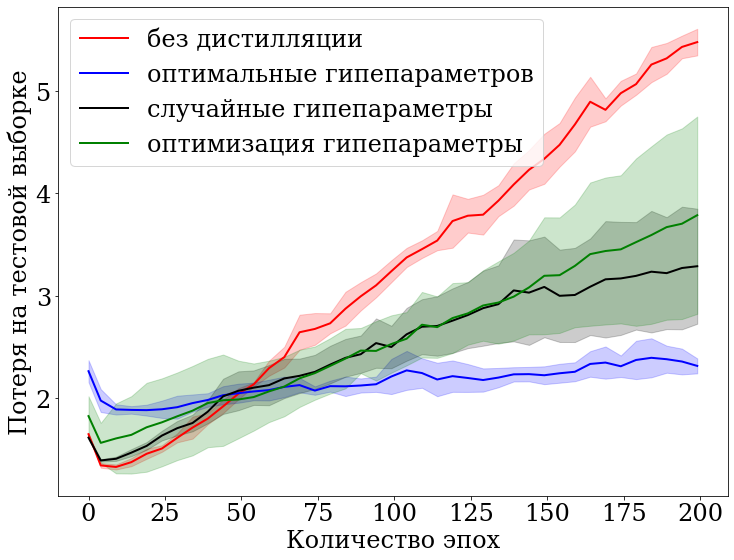

In [27]:
from matplotlib import pylab as plt
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
loss_b = np.array([subdata['results'][i]['test loss'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, loss_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, loss_b.mean(1)-loss_b.std(1), loss_b.mean(1)+loss_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
loss_d = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, loss_d.mean(1), '-', color='blue', label='оптимальные гипепараметров')
plt.fill_between(epoch_d, loss_d.mean(1)-loss_d.std(1), loss_d.mean(1)+loss_d.std(1), alpha=0.2, color='blue')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
loss_dr = np.array([subdata['results'][i]['test loss'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_dr.shape[0], -1)
plt.plot(epoch_dr, loss_dr.mean(1), '-', color='black', label='случайные гипепараметры')
plt.fill_between(epoch_dr, loss_dr.mean(1)-loss_dr.std(1), loss_dr.mean(1)+loss_dr.std(1), alpha=0.2, color='black')


epoch_h = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
loss_h = np.array([subdata['results'][i]['test loss'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, loss_h.mean(1), '-', color='green', label='оптимизация гипепараметры')
plt.fill_between(epoch_h, loss_h.mean(1)-loss_h.std(1), loss_h.mean(1)+loss_h.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Потеря на тестовой выборке')

plt.legend()
plt.savefig('loss.pdf')

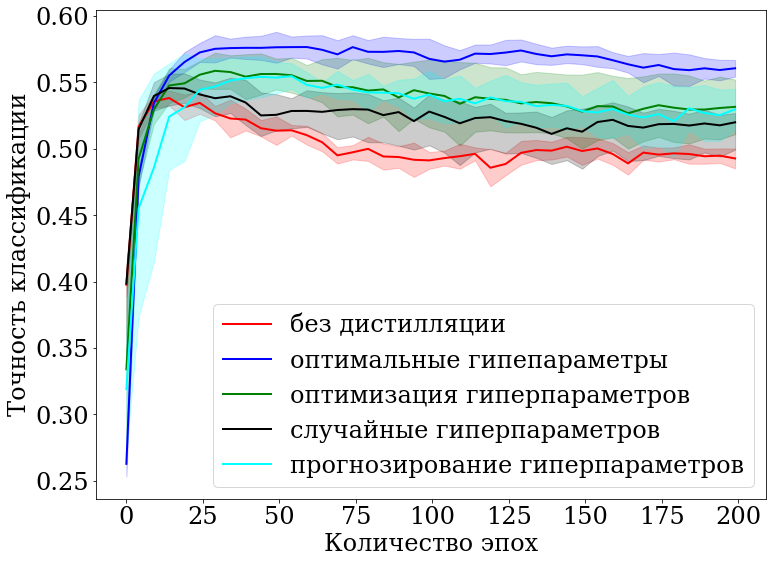

In [28]:
epoch_b = np.array([data_b[2]['results'][i]['epoch'] for i in range(len(data_b[0]['results']))])
acc_b = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_b[0]['results'])) for subdata in data_b]).reshape(epoch_b.shape[0], -1)
plt.plot(epoch_b, acc_b.mean(1), '-', color='red', label='без дистилляции')
plt.fill_between(epoch_b, acc_b.mean(1)-acc_b.std(1), acc_b.mean(1)+acc_b.std(1), alpha=0.2, color='red')

epoch_d = np.array([data_d[2]['results'][i]['epoch'] for i in range(len(data_d[2]['results']))])
acc_d = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_d]).reshape(epoch_d.shape[0], -1)
plt.plot(epoch_d, acc_d.mean(1), '-', color='blue', label='оптимальные гипепараметры')
plt.fill_between(epoch_d, acc_d.mean(1)-acc_d.std(1), acc_d.mean(1)+acc_d.std(1), alpha=0.2, color='blue')

epoch_h = np.array([data_h[2]['results'][i]['epoch'] for i in range(len(data_h[2]['results']))])
acc_h = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_d[0]['results'])) for subdata in data_h]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_h, acc_h.mean(1), '-', color='green', label='оптимизация гиперпараметров')
plt.fill_between(epoch_h, acc_h.mean(1)-acc_h.std(1), acc_h.mean(1)+acc_h.std(1), alpha=0.2, color='green')

epoch_dr = np.array([data_dr[2]['results'][i]['epoch'] for i in range(len(data_dr[2]['results']))])
acc_dr = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_dr[0]['results'])) for subdata in data_dr]).reshape(epoch_h.shape[0], -1)
plt.plot(epoch_dr, acc_dr.mean(1), '-', color='black', label='случайные гиперпараметров')
plt.fill_between(epoch_dr, acc_dr.mean(1)-acc_h.std(1), acc_dr.mean(1)+acc_dr.std(1), alpha=0.2, color='black')

epoch_s = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_s[2]['results']))])
acc_s = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_s[0]['results'])) for subdata in data_s]).reshape(epoch_s.shape[0], -1)
plt.plot(epoch_s, acc_s.mean(1), '-', color='cyan', label='прогнозирование гиперпараметров')
plt.fill_between(epoch_s, acc_s.mean(1)-acc_s.std(1), acc_s.mean(1)+acc_s.std(1), alpha=0.2, color='cyan')


plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc.pdf')

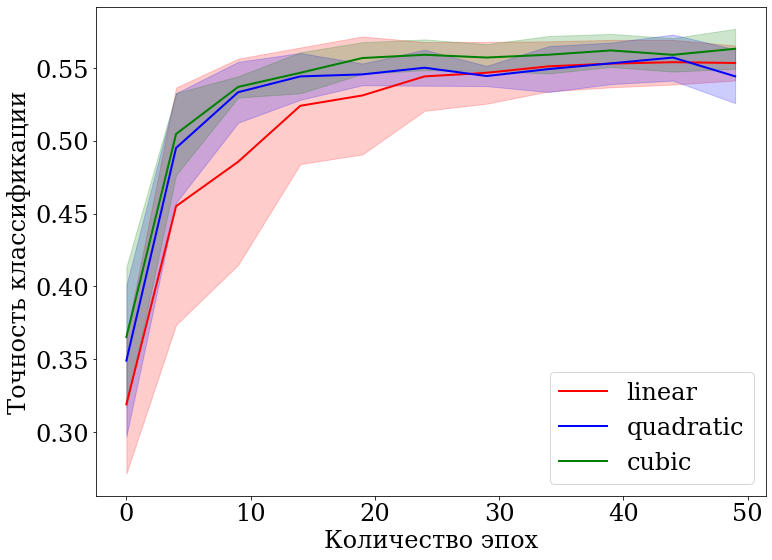

In [53]:
with open("exp8_dist_h_b2_optim.jsonl", "r") as read_file:
    data_l = [json.loads(line) for line in read_file]
with open("exp9_dist_h_b2_optim.jsonl", "r") as read_file:
    data_q = [json.loads(line) for line in read_file]
with open("exp10_dist_h_b2_optim.jsonl", "r") as read_file:
    data_c = [json.loads(line) for line in read_file]

epoch_l = np.array([data_l[2]['results'][i]['epoch'] for i in range(len(data_l[2]['results']))])
acc_l = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_l[0]['results'])) for subdata in data_l]).reshape(epoch_l.shape[0], -1)
plt.plot(epoch_l[0:11], acc_l[0:11].mean(1), '-', color='red', label='linear')
plt.fill_between(epoch_l[0:11], acc_l[0:11].mean(1)-acc_l[0:11].std(1), acc_l[0:11].mean(1)+acc_l[0:11].std(1), alpha=0.2, color='red')

epoch_q = np.array([data_s[2]['results'][i]['epoch'] for i in range(len(data_q[2]['results']))])
acc_q = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_q[0]['results'])) for subdata in data_q]).reshape(epoch_q.shape[0], -1)
plt.plot(epoch_q, acc_q.mean(1), '-', color='blue', label='quadratic')
plt.fill_between(epoch_q, acc_q.mean(1)-acc_q.std(1), acc_q.mean(1)+acc_q.std(1), alpha=0.2, color='blue')

epoch_c = np.array([data_c[2]['results'][i]['epoch'] for i in range(len(data_c[2]['results']))])
acc_c = np.array([subdata['results'][i]['accuracy'] for i in range(len(data_c[0]['results'])) for subdata in data_c]).reshape(epoch_c.shape[0], -1)
plt.plot(epoch_c, acc_c.mean(1), '-', color='green', label='cubic')
plt.fill_between(epoch_c, acc_c.mean(1)-acc_c.std(1), acc_c.mean(1)+acc_c.std(1), alpha=0.2, color='green')

plt.xlabel('Количество эпох')
plt.ylabel('Точность классификации')
plt.legend()
plt.savefig('acc_splines.pdf')